# Visual Recognition HW1 - Semantic segmentation

## Overview
The goal of this task is to finish the implementation of a semantic segmentation model based on the [BiFPN](https://arxiv.org/abs/1911.09070) approach.
And test the capabilities of the model on [VOC 2011 dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2011/index.html).

To be more precise the model will input a batch of RGB images of shape `(BATCH, 3, IMAGE_HEIGHT, IMAGE_WIDTH)` and output a segmentation mask `m` of shape `(BATCH, #CLASS, PREDICTION_HEIGHT, PREDICTION_WIDTH)`, where `#CLASS` is the number of classes in the VOC2011 segmentation dataset.  
The mask will be such that
* `m[:, i]` equals 1, whether the element of the image corresponds to the object of the `i`-th class in the VOC 2011 segmentation dataset,

This notebook is divided into several sections:
* Preparation - 0 points (everything is already implemented)
  * Installation and imports of packages
  * code for preparation of the dataset
  * utils for visualization
* Model implementation - 2 points

* Training and evaluation - 3 points
  * metrics - 1 point
  * eval loop - 1 points
  * train loop - 1 point
* Inspection and Ablations - 5 points
  * finding best and worst predictions 2 points,
  * ablations - 3 points,


## General information
Please write the code within
```python
## TODO {

## }
```
blocks.

You can also modify other parts of the code if necessary.

You don't have to strictly adhere to the suggested code structure. You can change the flow and use custom implementations as long as the defined tasks are fulfilled.

## Preparation - 0 points

### Libraries

In [1]:
# A package for visualizing the architecture of the model
!pip install torchinfo

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchinfo
from typing import List, Optional, Tuple

### Dataset

In [3]:
# We downscale images to
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# We will make predictions in a smaller scale
PREDICTION_HEIGHT = 64
PREDICTION_WIDTH = 64


# We want to match data distribution
# of the backbone that we will introduce later
image_net_mean = [0.485, 0.456, 0.406]
image_net_std = [0.229, 0.224, 0.225]

# Custom transform to map the void class id 255 -> -1
# class Map255ToMinus1:
#     def __call__(self, tensor):
#         tensor[tensor == 255] = 0
#         return tensor

input_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        torchvision.transforms.ToTensor(),  # our input is an image
        torchvision.transforms.Normalize(image_net_mean, image_net_std),
    ]
)

target_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(
            (PREDICTION_HEIGHT, PREDICTION_WIDTH),
            interpolation=torchvision.transforms.InterpolationMode.NEAREST,
        ),
        torchvision.transforms.PILToTensor(),  # gives uint8
        torchvision.transforms.Lambda(lambda x: (x.squeeze(-3)).type(torch.long)),
        # Map255ToMinus1(),
    ]
)


In [4]:
import torchvision

# Directory for dataset storage
DATA_PATH = "~/torch_datasets/voc"

TRAIN_DATASET = torchvision.datasets.VOCSegmentation(
    root=DATA_PATH,
    year="2011",
    image_set="train",
    download=True,
    transform=input_transforms,
    target_transform=target_transforms,
)

TEST_DATASET = torchvision.datasets.VOCSegmentation(
    root=DATA_PATH,
    year="2011",
    image_set="val",
    download=True,
    transform=input_transforms,
    target_transform=target_transforms,
)

100%|██████████| 1.77G/1.77G [01:21<00:00, 21.6MB/s]


In [5]:
BATCH_SIZE = 32
TRAIN_LOADER = torch.utils.data.DataLoader(
    TRAIN_DATASET, shuffle=True, batch_size=BATCH_SIZE
)
TEST_LOADER = torch.utils.data.DataLoader(
    TEST_DATASET, shuffle=True, batch_size=BATCH_SIZE
)

In [6]:
samples = next(iter(TRAIN_LOADER))
images, masks = samples

assert len(images.shape) == 4
assert images.shape[0] == BATCH_SIZE
assert images.shape[1] == 3
assert images.shape[2] == IMAGE_HEIGHT
assert images.shape[3] == IMAGE_WIDTH
assert images.dtype == torch.float32

assert len(masks.shape) == 3
assert masks.shape[0] == BATCH_SIZE
assert masks.shape[1] == PREDICTION_HEIGHT
assert masks.shape[2] == PREDICTION_WIDTH
assert masks.dtype == torch.long

In [7]:
num_batches_test = len(TEST_LOADER)
num_samples_test = len(TEST_LOADER.dataset)

num_batches_train = len(TRAIN_LOADER)
num_samples_train = len(TRAIN_LOADER.dataset)

print(num_batches_test, num_samples_test)
print(num_batches_train, num_samples_train)

35 1111
35 1112


### Utils

In [8]:

def visualize_data(images, masks):
    """
    Args:
        images: tensor of shape (BATCH, 3, H, W)
        masks: tensor of shape (BATCH, H, W)
    """
    assert len(images.shape) == 4
    num_images = images.shape[0]
    assert masks.shape[0] == num_images

    m1, m2, m3 = (
        ((masks == 1) | (masks==2) | (masks == 3) | (masks == 4) | (masks == 5) | (masks == 6)).type(torch.long),
        ((masks == 7) | (masks == 8) | (masks == 9) | (masks == 10) | (masks == 11) | (masks == 12)).type(torch.long),
        ((masks == 13) | (masks == 14) | (masks == 15) | (masks == 16) | (masks == 17) | (masks == 18)).type(torch.long),
    )
    _, axes = plt.subplots(num_images, 4, figsize=(32, 32))

    for i, (img, p, o, b) in enumerate(zip(images, m1, m2, m3)):
        axes[i, 0].axis("off")
        axes[i, 0].imshow(np.clip(img.permute(1, 2, 0).numpy()/4.5 + 0.5, 0, 1))
        axes[i, 1].axis("off")
        axes[i, 1].imshow(p)
        axes[i, 2].axis("off")
        axes[i, 2].imshow(o)
        axes[i, 3].axis("off")
        axes[i, 3].imshow(b)

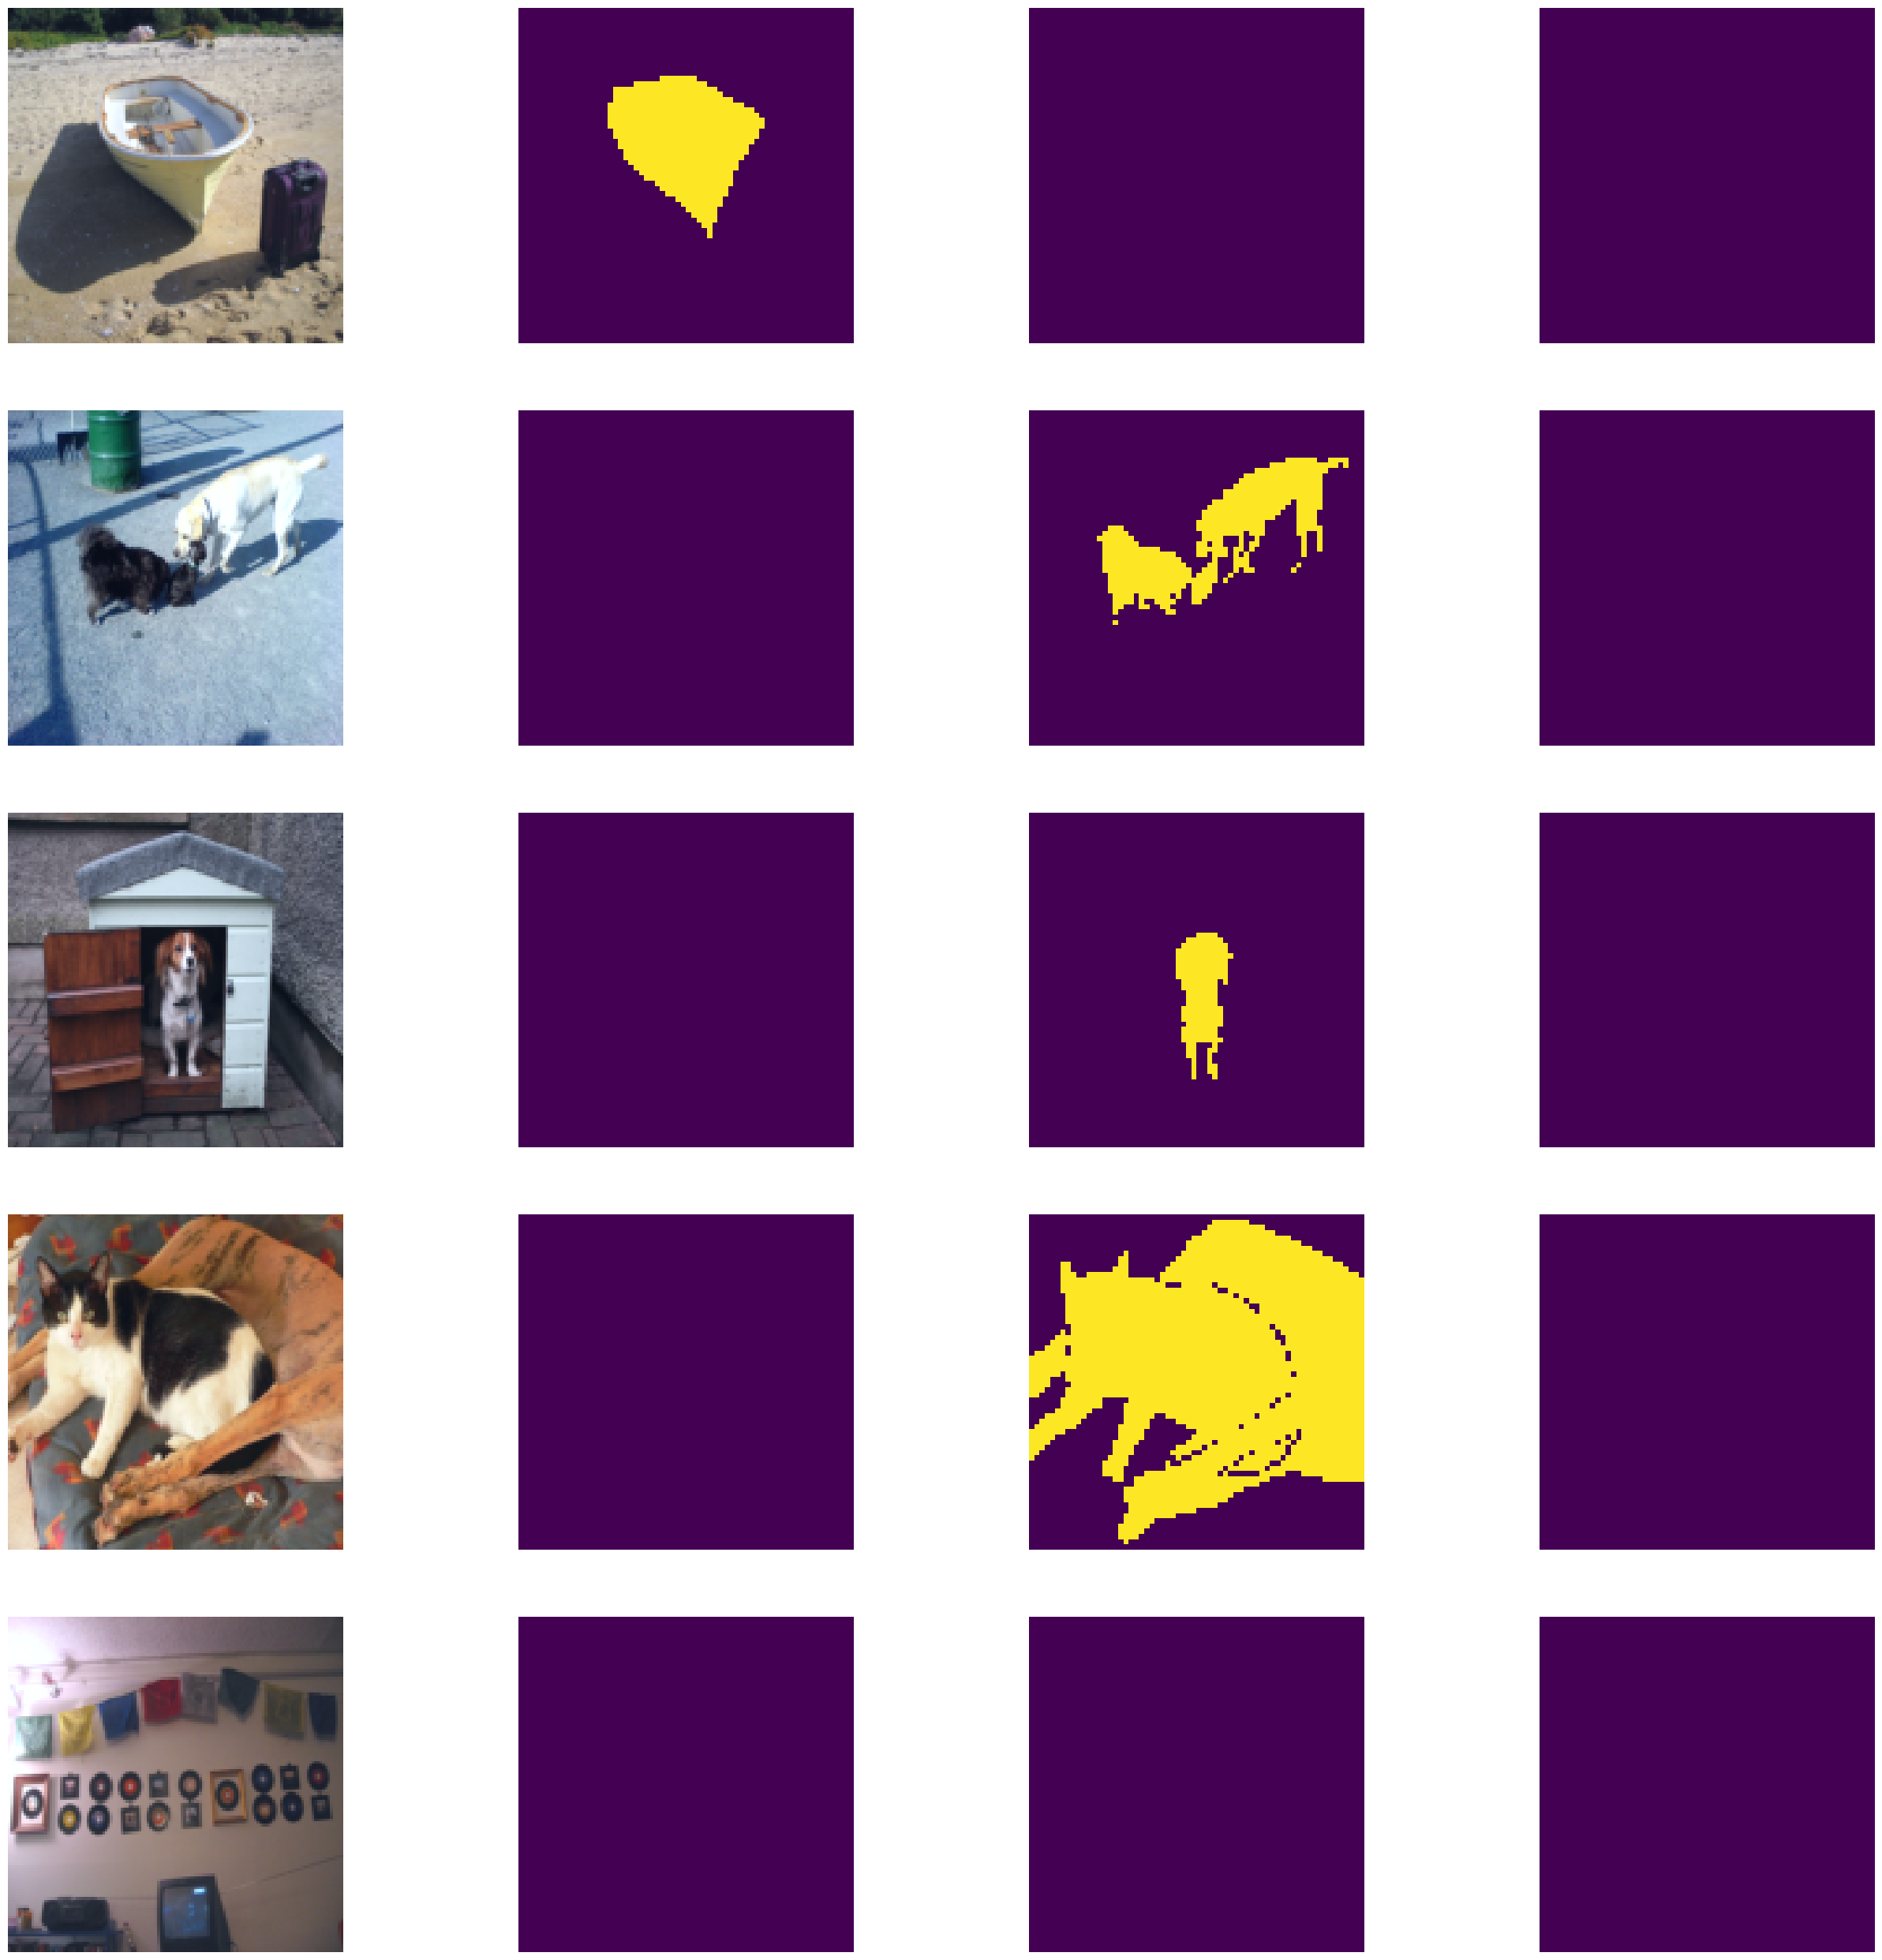

In [9]:
visualize_data(images[:5], masks[:5])

## Model Implementation - 2 points


### Backbone preparation
Here, you will download the EfficientNet model and create classes that will allow you to extract features from the downloaded model. By features, we mean outputs of specified layers.

### EfficientNet Feature Extraction
First, let's download and inspect the model.

In [10]:
def get_efficient_net():
    return torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

def get_example_input():
    return torch.rand(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH) # [B, C, H, W]

efficient_net = get_efficient_net()
print(torchinfo.summary(efficient_net, input_size=(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)))
print(efficient_net)

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

Layer (type:depth-idx)                                       Output Shape              Param #
EfficientNet                                                 [1, 1000]                 --
├─Sequential: 1-1                                            [1, 32, 64, 64]           --
│    └─Conv2d: 2-1                                           [1, 32, 64, 64]           864
│    └─BatchNorm2d: 2-2                                      [1, 32, 64, 64]           64
│    └─SiLU: 2-3                                             [1, 32, 64, 64]           --
├─Sequential: 1-2                                            [1, 320, 4, 4]            --
│    └─Sequential: 2-4                                       [1, 16, 64, 64]           --
│    │    └─MBConvBlock: 3-1                                 [1, 16, 64, 64]           1,448
│    └─Sequential: 2-5                                       [1, 24, 32, 32]           --
│    │    └─MBConvBlock: 3-2                                 [1, 24, 32, 32]           6,00

In [11]:
# get resnet50
def get_resnet50():
    return torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)

def get_example_input():
    return torch.rand(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)  # [B, C, H, W]

resnet50 = get_resnet50()
example_input = get_example_input()

print(torchinfo.summary(resnet50, input_size=(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)))
print(resnet50)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/resnet50_pyt_amp/versions/20.06.0/files/nvidia_resnet50_200821.pth.tar" to /root/.cache/torch/hub/checkpoints/nvidia_resnet50_200821.pth.tar
100%|██████████| 97.7M/97.7M [00:00<00:00, 335MB/s]


Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [1, 1000]                 --
├─Conv2d: 1-1                                 [1, 64, 64, 64]           9,408
├─BatchNorm2d: 1-2                            [1, 64, 64, 64]           128
├─ReLU: 1-3                                   [1, 64, 64, 64]           --
├─MaxPool2d: 1-4                              [1, 64, 32, 32]           --
├─Sequential: 1-5                             [1, 2048, 4, 4]           --
│    └─Sequential: 2-1                        [1, 256, 32, 32]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 32, 32]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 32, 32]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 32, 32]          70,400
│    └─Sequential: 2-2                        [1, 512, 16, 16]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 16, 16]          379,392

Fill in the code below according to the docstrings.  
There are several approaches to the task below one of them is to use `register_forward_hook`.  
The other one is to replace selected modules with appropriate wrappers.

In [12]:
class EffNetFeatureExtractor(torch.nn.Module):
    """
    Accepts an efficient_net and an list of layers for feature extraction (feature_layer_ids).
    When called returns a list containing the outputs of the selected layers.
    The parameter feature_layer_ids specifies the ids of the layers from
    efficient_net.layers.
    To be more precise for feature_layer_ids = [4, 6] it returns a list containing outputs of
    self.efficient_net.layers[4] and self.efficient_net.layers[6].
    """

    def __init__(
        self, efficient_net, feature_layer_ids: List[int]
    ) -> None:
        super().__init__()

        self.efficient_net = efficient_net
        self.feature_layer_ids = feature_layer_ids

        ## TODO {

        self.layers_output = []

        def forward_hook(module, input, output):
            self.layers_output.append(output)

        for idx in self.feature_layer_ids:
            layer = self.efficient_net.layers[idx]
            layer.register_forward_hook(forward_hook)

        ## }

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:

        ## TODO {

        self.layers_output.clear()

        _ = self.efficient_net(x)
        extracted_features = self.layers_output

        ## }
        return extracted_features


def get_extracted_feature_shapes(net: EffNetFeatureExtractor):
    extracted_features = net(get_example_input())
    extracted_feature_shapes = [ef.shape for ef in extracted_features]
    return extracted_feature_shapes


##### TESTS START #####


def test_feature_extraction():
    efficient_net = get_efficient_net()
    net = EffNetFeatureExtractor(
        efficient_net=efficient_net, feature_layer_ids=[i for i in range(0, 7, 2)]
    )
    extracted_feature_shapes = get_extracted_feature_shapes(net)
    extracted_feature_shapes = get_extracted_feature_shapes(net) # this is on purpose

    expected_feature_shapes = [
        (1, 16, 64, 64),
        (1, 40, 16, 16),
        (1, 112, 8, 8),
        (1, 320, 4, 4),
    ]
    assert len(extracted_feature_shapes) == len(expected_feature_shapes)
    for extracted_fs, expected_fs in zip(
        extracted_feature_shapes, expected_feature_shapes
    ):
        assert extracted_fs == expected_fs


test_feature_extraction()

#####  TESTS END  #####

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


### Feature extractor for the Resnet50 backbone

Implement analogous feature extractor as above , but for the ResNet50 backbone.

In [13]:
class ResNet50FeatureExtractor(torch.nn.Module):
## TODO {

    def __init__(
        self, res_net, feature_layer_ids: List[int]
    ) -> None:
        super().__init__()

        self.res_net = res_net
        self.feature_layers_ids = feature_layer_ids

        self.layers_output = []

        def forward_hook(module, input, output):
            self.layers_output.append(output)

        for idx in self.feature_layers_ids:
            layer = self.res_net.layers[idx]
            layer.register_forward_hook(forward_hook)



    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:
        self.layers_output.clear()

        _ = self.res_net(x)

        return self.layers_output

## }

### Feature Channel Matching
In BiFPN we want all features to have the same number of channels (so we can add them easily).  
  
`MatchChannels` is already implemented.

Of course , you can use your own implementation of the backbone and MatchChannels.

In [14]:
class MatchChannels(torch.nn.Module):
    """
    Given the input of shape (BATCH, in_channels, H, W),
    converts it to the one of shape (BATCH, out_channels, H, W)
    """

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1
        )
        self.bn = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert len(x.shape) == 4
        x = self.conv(x)
        x = self.bn(x)
        return x


class EffNetBackboneWrapper(torch.nn.Module):
    """
    Given a efficient net backbone and channel_matching_fn (a function of form lambda x: MatchChannels(x, c))
    runs backbone to extract the features and uses modules created using channel_matching_fn to
    make channel dimension equal in all features.

    UPDATE: freezing gradients is NOT recommended.
    """

    def __init__(self, backbone: EffNetFeatureExtractor, channel_matching_fn):
        super().__init__()
        self.backbone = backbone

        ## TODO {

        with torch.no_grad():
            extracted_features = self.backbone(get_example_input())
            in_channels = [ef.shape[1] for ef in extracted_features]

        self.match_channels = torch.nn.ModuleList([
            channel_matching_fn(in_ch) for in_ch in in_channels
        ])

        ## }

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:

        ## TODO {

        extracted_features = self.backbone(x)

        channel_matched_features = [
            mc(ef) for mc, ef in zip(self.match_channels, extracted_features)
        ]

        ## }

        return channel_matched_features

##the same backbone wrapper for the other Resnet50 backbone
class Resnet50BackboneWrapper(torch.nn.Module):
## TODO {

    def __init__(self, backbone: ResNet50FeatureExtractor, channel_matching_fn):
        super().__init__()

        self.backbone = backbone

        with torch.no_grad():
            extracted_features = self.backbone(get_example_input())
            in_channels = [ef.shape[1] for ef in extracted_features]

        self.match_channels = torch.nn.ModuleList([
            channel_matching_fn(in_ch) for in_ch in in_channels
        ])


    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:

        extracted_features = self.backbone(x)

        channel_matched_features = [
            mc(ef) for mc, ef in zip(self.match_channels, extracted_features)
        ]

        return channel_matched_features

## }

##### TESTS START #####


def test_backbone_basic():
    efficient_net = get_efficient_net()
    net = EffNetFeatureExtractor(
        efficient_net=efficient_net, feature_layer_ids=[i for i in range(0, 7, 2)]
    )

    wrapped = EffNetBackboneWrapper(
        backbone=net, channel_matching_fn=lambda x: MatchChannels(x, 24)
    )

    out = wrapped(get_example_input())

    out_shapes = [feature.shape for feature in out]

    expected_feature_shapes = [
        (1, 24, 64, 64),
        (1, 24, 16, 16),
        (1, 24, 8, 8),
        (1, 24, 4, 4),
    ]
    assert len(out_shapes) == len(expected_feature_shapes)
    for extracted_fs, expected_fs in zip(out_shapes, expected_feature_shapes):
        assert extracted_fs == expected_fs


test_backbone_basic()

#

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


### BiFPN - Feature Fusion
Now we will implement the BiFPN network. Starting with single-way feature fusion, and then stacked multiple.   
Complete the code below according to docstrings.

In [15]:
class BiFPNSingle(torch.nn.Module):
    """
    Given list of height features (list of length height),
    with each feature having feature_channels channels
    (that is i'th feature has shape (BATCH, feature_channels, H_i, W_i))
    performs the following sequence of operations
    res[0] = feature_list[0]
    res[i] = ACT(BN(CONVS(w[i][1] * feature_list[i] + w[i][2]*RESIZE(res[i-1]) + w[i][3]*aux_feature_list[i])))
    where the part w[i][3]*aux_feature_list[i] is present only when aux_feature_list is not None
    and weights w are calculated like in the BiFPN paper.
    Choice of CONVS is not specified."""

    def __init__(self, feature_channels: int, height: int) -> None:
        super().__init__()
        self.height = height
        self.weights = torch.nn.ParameterList([
            torch.nn.Parameter(torch.ones(3, dtype=torch.float32))
            for _ in range(height - 1)
        ])
        self.convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(feature_channels, feature_channels, kernel_size=3, padding=1),
                torch.nn.BatchNorm2d(feature_channels),
                torch.nn.ReLU()
            )
            for _ in range(height - 1)
        ])

    def normalize_weights(self, weights: torch.Tensor):
        """
        Makes weights "add up to one", uses either softmax or the
        method from the BiFPN paper.
        """
        weights = weights + 1e-4  # Add a small epsilon to avoid division by zero
        weights = weights / torch.sum(weights)
        return weights

    def forward(
        self,
        feature_list: List[torch.Tensor],
        aux_feature_list: Optional[List[torch.Tensor]] = None,
    ) -> List[torch.Tensor]:
        ## TODO {

        result = [feature_list[0]]
        for i in range(1, self.height):
            weights = self.normalize_weights(self.weights[i-1])

            resized_prev = torch.nn.functional.interpolate(
                input=result[-1],
                size=feature_list[i].shape[-2:],
                mode='bilinear'
            )

            weighted_sum = weights[0] * feature_list[i] + weights[1] * resized_prev

            if aux_feature_list is not None:
                weighted_sum += weights[2] * aux_feature_list[i]

            result.append(self.convs[i-1](weighted_sum))

        ## }

        return result




##### TESTS START #####


def test_bifpn_single():

    bifpn_single = BiFPNSingle(32, 3)

    input_data = [
        torch.randn(1, 32, 64, 64),
        torch.randn(1, 32, 32, 32),
        torch.randn(1, 32, 7, 7),
    ]

    out = bifpn_single(input_data)

    assert len(out) == len(input_data)
    for o, i in zip(out, input_data):
        print(o.shape == i.shape)
        assert o.shape == i.shape


test_bifpn_single()
#####  TESTS END  #####

True
True
True


In [16]:
class BiFPN(torch.nn.Module):
    """
    Uses two BiFPNSingle modules to implement a BiFPN module as in the BiFPN paper.
    """
    def __init__(self, feature_channels: int, height: int) -> None:
    ## TODO {

        super().__init__()

        self.top_down = BiFPNSingle(feature_channels, height)
        self.bottom_up = BiFPNSingle(feature_channels, height)

    def forward(self, feature_list: List[torch.Tensor]) -> List[torch.Tensor]:

        td_features = self.top_down(feature_list)

        reversed_td = list(reversed(td_features))
        reversed_orig = list(reversed(feature_list))


        bottom_up_features = self.bottom_up(reversed_td, reversed_orig)

        return list(reversed(bottom_up_features))

    ## }


##### TESTS START #####


def test_bifpn():

    bifpn = BiFPN(32, 3)

    input_data = [
        torch.randn(1, 32, 64, 64),
        torch.randn(1, 32, 32, 32),
        torch.randn(1, 32, 7, 7),
    ]

    out = bifpn(input_data)

    assert len(out) == len(input_data)
    for o, i in zip(out, input_data):
        assert o.shape == i.shape


test_bifpn()
#####  TESTS END  #####

In [17]:
class StackedBiFPN(torch.nn.Module):
    """
    Stacks multiple BiFPN modules for deep feature fusion in segmentation tasks.
    when num_repeats == 1 it is equivalent to BiFPN above (just single module),
    for num_repeats > 1 implements num_repeats  linearly stacked BiFPN modules
    """
    def __init__(self, num_repeats: int, feature_channels: int, height: int) -> None:
    ## TODO {
        super().__init__()

        self.bifpn_layers = torch.nn.ModuleList([
            BiFPN(feature_channels, height) for _ in range(num_repeats)
        ])

    def forward(self, feature_list: List[torch.Tensor]) -> List[torch.Tensor]:
        x = feature_list
        for bifpn in self.bifpn_layers:
            x = bifpn(x)

        return x


    ## }


### Segmentation Head

In [18]:
class SegmentationHead(torch.nn.Module):
    """
    Given an input of shape (B, feature_channels, H, W)
    Produces the output of shape (B, num_classes, H', W') (where H', W' = output_shape)
    consisting of logits (that is no activation in the last layer) that can be used to classify each pixel.
    To do so uses additional convolution(s) that operate on input with inner_channels channels.
    """

    def __init__(
        self,
        feature_channels: int,
        output_shape: Tuple[int, int] = (PREDICTION_HEIGHT, PREDICTION_WIDTH),
        inner_channels: int = 256,
        num_classes: int = 21,
    ):
        super().__init__()
        self.output_shape = output_shape
        self.num_classes = num_classes
        ## TODO {

        self.seq = torch.nn.Sequential(
            torch.nn.Conv2d(feature_channels, inner_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(inner_channels),
            torch.nn.ReLU()
        )
        self.final_conv = torch.nn.Conv2d(inner_channels, num_classes, kernel_size=1)
        self.upsample = torch.nn.Upsample(size=output_shape, mode='bilinear', align_corners=True)

        ## }

    def forward(self, x):
        ## TODO {

        x = self.seq(x)
        x = self.final_conv(x)
        result = self.upsample(x)

        ## }

        assert result.shape[0] == x.shape[0]
        assert result.shape[1] == self.num_classes
        assert result.shape[2:] == self.output_shape
        return result

### Network

In [19]:
class Net(torch.nn.Module):
    """
    input parameters (defaults provided):
    * num_repeats - nr# of BiFPNSingle modules,
    * backbone - either 'efficientnet' or 'resnet50'

    Given an input of shape (BATCH, 3, H, W)
    returns a tensor of shape (BATCH, #CLASS, H', W') (where H', W' = output_shape)
    """

    def __init__(
        self,
        num_repeats = 1,
        backbone = 'efficientnet',
        feature_channels: int = 256,
        output_shape: Tuple[int, int] = (PREDICTION_HEIGHT, PREDICTION_WIDTH),
        feature_layer_ids: List[int] = [0, 1, 2, 3, 4, 5, 6], # will update some reccomended channels here
    ) -> None:
        super().__init__()

        ## TODO {

        if backbone == 'efficientnet':
            efficient_net = get_efficient_net()
            net = EffNetFeatureExtractor(
                efficient_net=efficient_net, feature_layer_ids=feature_layer_ids
            )

            self.match_channels = EffNetBackboneWrapper(
                backbone=net, channel_matching_fn=lambda x: MatchChannels(x, feature_channels)
            )
        elif backbone == 'resnet50':
            res_net = get_resnet50()
            net = ResNet50FeatureExtractor(
                res_net=res_net, feature_layer_ids=feature_layer_ids
            )

            self.match_channels = Resnet50BackboneWrapper(
                backbone=net, channel_matching_fn=lambda x: MatchChannels(x, feature_channels)
            )
        else:
            raise


        self.stacked_bifpn = StackedBiFPN(
            num_repeats=num_repeats,
            feature_channels=feature_channels,
            height=len(feature_layer_ids)
        )

        self.head = SegmentationHead(
            feature_channels=feature_channels,
            output_shape=output_shape
        )

        ## }

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ## TODO {

        matched_channels_features = self.match_channels(x)
        bifpn_features = self.stacked_bifpn(matched_channels_features)
        result = self.head(bifpn_features[0])

        ## }
        return result

## Training and Evaluation - 3 points

### Metrics - 1 point

Implement however you wish the four  metrics: accuracy  , mIoU (IoU for all classes at once), Frequency Weighted IoU.

In [20]:
VOID_LABEL = 255

def accuracy_per_class(prediction: np.ndarray, ground_truth: np.ndarray):
    void_label = 255
    valid = (ground_truth >= 0) & (ground_truth != VOID_LABEL)

    classes = np.unique(ground_truth[valid])
    accuracies = {}

    for cl in classes:
        mask = (ground_truth == cl) & valid
        total = mask.sum()
        if total == 0:
            accuracies[int(cl)] = 0
        else:
            correct = (prediction[mask] == cl).sum()
            accuracies[int(cl)] = correct / total

    return accuracies


def accuracy(prediction: np.ndarray, ground_truth: np.ndarray) -> np.ndarray:
    ## TODO {

    valid = (ground_truth >= 0) & (ground_truth != VOID_LABEL)
    correct = (prediction[valid] == ground_truth[valid]).sum()
    return correct / valid.sum()

    ## }
def miou_metric(prediction: np.ndarray, ground_truth: np.ndarray):
    ## TODO {
    valid = (ground_truth >= 0) & (ground_truth != VOID_LABEL)

    classes = np.unique(ground_truth[valid])
    ious = {}

    sum_iou = 0
    count = 0

    for cl in classes:
        pred_mask = (prediction == cl) & valid
        true_mask = (ground_truth == cl) & valid

        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()

        iou = intersection / union if union > 0 else 0
        ious[int(cl)] = iou

        sum_iou += iou
        count += 1

    miou = sum_iou / count if count > 0 else 0
    return ious, miou

    ## }
def frequency_weighted_iou(prediction: np.ndarray, ground_truth: np.ndarray):
    ## TODO {
    valid = (ground_truth >= 0) & (ground_truth != VOID_LABEL)

    classes = np.unique(ground_truth[valid])

    ious = []
    freqs = []

    for cl in classes:
        pred_mask = (prediction == cl) & valid
        true_mask = (ground_truth == cl) & valid
        freq = true_mask.sum()

        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()

        iou = intersection / union if union > 0 else 0
        ious.append(iou)
        freqs.append(freq)

    total_pixels = np.sum(freqs)
    if total_pixels == 0:
        return 0

    weighted_ious = np.sum(np.array(ious) * np.array(freqs)) / total_pixels

    return weighted_ious

    ## }

### Eval Loop - 1point

In [21]:

DEVICE = torch.device("cuda")

#UPDATE: removed one_hot_prediction (it is unnecessary)

@torch.no_grad
def eval_fn(model, test_loader):
    model.to(DEVICE)
    model.eval()

    all_preds = []
    all_gts = []

    for data in test_loader:
        x, y = data
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        prediction = torch.argmax(logits.detach(), dim=-3, keepdim=False)

        #collect accuracy  , mIoU, Frequency Weighted IoU
        ## TODO {

        all_preds.append(prediction.cpu().numpy())
        all_gts.append(y.cpu().numpy())

    pred_stack = np.vstack(all_preds)
    gt_stack = np.vstack(all_gts)

    acc_pixel = accuracy(pred_stack, gt_stack)
    acc_per_class = accuracy_per_class(pred_stack, gt_stack)
    ious, miou = miou_metric(pred_stack, gt_stack)
    fw_iou = frequency_weighted_iou(pred_stack, gt_stack)

    return acc_pixel, acc_per_class, ious, miou, fw_iou

        ## }

#collect accuracy  , mIoU, Frequency Weighted IoU
#print metrics for all classes
## TODO {

model = Net()
acc_pixel, acc_per_class, ious, miou, fw_iou = eval_fn(model, TEST_LOADER)
def print_metrics(acc_pixel, acc_class, ious, miou, fw_iou):
    print(f"Pixel accuracy: {acc_pixel:.4f}")

    print("\nAccuracy per class:")
    for cl in sorted(acc_per_class):
        print(f"Class {cl} accuracy: {acc_per_class[cl]:.4f}")

    print("\nIoU per class:")
    for cl in sorted(ious):
        print(f"Class {cl} IoU: {ious[cl]:.4f}")

    print(f"\nMean IoU: {miou:.4f}")
    print(f"\nFrequency weighted IoU: {fw_iou:.4f}")

print_metrics(acc_pixel, acc_per_class, ious, miou, fw_iou)

## }

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Pixel accuracy: 0.0224

Accuracy per class:
Class 0 accuracy: 0.0134
Class 1 accuracy: 0.0001
Class 2 accuracy: 0.0099
Class 3 accuracy: 0.0526
Class 4 accuracy: 0.0560
Class 5 accuracy: 0.1305
Class 6 accuracy: 0.2788
Class 7 accuracy: 0.0003
Class 8 accuracy: 0.0000
Class 9 accuracy: 0.0118
Class 10 accuracy: 0.0011
Class 11 accuracy: 0.0108
Class 12 accuracy: 0.1274
Class 13 accuracy: 0.0062
Class 14 accuracy: 0.0070
Class 15 accuracy: 0.0042
Class 16 accuracy: 0.0001
Class 17 accuracy: 0.1820
Class 18 accuracy: 0.0715
Class 19 accuracy: 0.0001
Class 20 accuracy: 0.0107

IoU per class:
Class 0 IoU: 0.0133
Class 1 IoU: 0.0001
Class 2 IoU: 0.0042
Class 3 IoU: 0.0095
Class 4 IoU: 0.0038
Class 5 IoU: 0.0103
Class 6 IoU: 0.0154
Class 7 IoU: 0.0003
Class 8 IoU: 0.0000
Class 9 IoU: 0.0041
Class 10 IoU: 0.0010
Class 11 IoU: 0.0049
Class 12 IoU: 0.0126
Class 13 IoU: 0.0031
Class 14 IoU: 0.0049
Class 15 IoU: 0.0038
Class 16 IoU: 0.0001
Class 17 IoU: 0.0098
Class 18 IoU: 0.0137
Class 19 IoU: 0

### Train Loop - 1 point

Complete the two training loops using the Net constructor with default values.
Use `CrossEntropyLoss` and the Dice loss .


In [23]:
def train_crossentropy(
    model,
    optimizer,
    train_loader,
    test_loader,
    num_epoch,
    eval_fn,
    #UPDATE: remove weights (unnecessary)
):
    ## TODO {

    criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

    for epoch in range(num_epoch):
        model.train()
        running_loss = 0

        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()

            logits = model(x)
            loss = criterion(logits, y)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % 5 == 0:
                print(f"[Epoch {epoch+1}/{num_epoch}] Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

        avg_train_loss = running_loss / len(train_loader)
        print(f'\nEpoch {epoch+1} Training Loss: {avg_train_loss:.4f}')

        model.eval()
        train_acc, train_acc_per_class, train_iou_per_class, train_miou, train_fw_iou = eval_fn(model, train_loader)
        print(f"Train eval metrics | Acc: {train_acc:.4f} | mIoU: {train_miou:.4f} | fw IoU: {train_fw_iou:.4f}")

        test_acc, test_acc_per_class, test_iou_per_class, test_miou, test_fw_iou = eval_fn(model, test_loader)
        print(f"Test eval metrics | Acc: {test_acc:.4f} | mIoU: {test_miou:.4f} | fw IoU: {test_fw_iou:.4f}\n")

    ## }

def train_dice(
    model,
    optimizer,
    train_loader,
    test_loader,
    num_epoch,
    eval_fn,
    #UPDATE: remove weights (unnecessary)
):
    ## TODO {

    smooth=1e-6

    for epoch in range(num_epoch):
        model.train()
        running_loss = 0

        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()

            logits = model(x)
            probs = torch.softmax(logits, dim=1)

            dice_loss = 0
            num_classes = probs.shape[1]

            for cl in range(num_classes):
                prob = probs[:, cl]
                target = (y == cl)

                intersection = (prob * target).sum()
                union = prob.sum() + target.sum()

                dice_score = 2 * intersection / (union + smooth)
                dice_loss += 1 - dice_score

            loss = dice_loss / num_classes
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % 5 == 0:
                print(f"[Epoch {epoch+1}/{num_epoch}] Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

        avg_train_loss = running_loss / len(train_loader)
        print(f'\nEpoch {epoch+1} Training Loss: {avg_train_loss:.4f}')

        model.eval()
        train_acc, train_acc_per_class, train_iou_per_class, train_miou, train_fw_iou = eval_fn(model, train_loader)
        print(f"Train eval metrics | Acc: {train_acc:.4f} | mIoU: {train_miou:.4f} | fw IoU: {train_fw_iou:.4f}")

        test_acc, test_acc_per_class, test_iou_per_class, test_miou, test_fw_iou = eval_fn(model, test_loader)
        print(f"Test eval metrics | Acc: {test_acc:.4f} | mIoU: {test_miou:.4f} | fw IoU: {test_fw_iou:.4f}\n")


    ## }

In [24]:
def create_model_and_optimizer(num_repeats, backbone, feature_layer_ids):
    model = Net(num_repeats=num_repeats, backbone=backbone, feature_layer_ids=feature_layer_ids)
    model.to(DEVICE)
    optimizer = torch.optim.Adam(params=model.parameters())
    return model, optimizer


#use at least num_repeats = 3

model, optimizer = create_model_and_optimizer(3, 'efficientnet', [2, 4, 6])
train_crossentropy(model, optimizer, TRAIN_LOADER, TEST_LOADER, 20, eval_fn)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


[Epoch 1/20] Batch 0/35 | Loss: 3.1926
[Epoch 1/20] Batch 5/35 | Loss: 2.0113
[Epoch 1/20] Batch 10/35 | Loss: 1.5719
[Epoch 1/20] Batch 15/35 | Loss: 1.1231
[Epoch 1/20] Batch 20/35 | Loss: 1.1450
[Epoch 1/20] Batch 25/35 | Loss: 0.9299
[Epoch 1/20] Batch 30/35 | Loss: 0.8326

Epoch 1 Training Loss: 1.3581
Train eval metrics | Acc: 0.7911 | mIoU: 0.1041 | fw IoU: 0.6675
Test eval metrics | Acc: 0.7737 | mIoU: 0.0957 | fw IoU: 0.6426

[Epoch 2/20] Batch 0/35 | Loss: 0.6292
[Epoch 2/20] Batch 5/35 | Loss: 0.8936
[Epoch 2/20] Batch 10/35 | Loss: 0.5801
[Epoch 2/20] Batch 15/35 | Loss: 0.6206
[Epoch 2/20] Batch 20/35 | Loss: 0.5115
[Epoch 2/20] Batch 25/35 | Loss: 0.7071
[Epoch 2/20] Batch 30/35 | Loss: 0.6655

Epoch 2 Training Loss: 0.7384
Train eval metrics | Acc: 0.8111 | mIoU: 0.1244 | fw IoU: 0.6748
Test eval metrics | Acc: 0.7878 | mIoU: 0.1098 | fw IoU: 0.6414

[Epoch 3/20] Batch 0/35 | Loss: 0.5587
[Epoch 3/20] Batch 5/35 | Loss: 0.6976
[Epoch 3/20] Batch 10/35 | Loss: 0.6955
[Epo

In [26]:
model1, optimizer = create_model_and_optimizer(3, 'efficientnet', [2, 4, 6])
train_dice(model1, optimizer, TRAIN_LOADER, TEST_LOADER, 20, eval_fn)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


[Epoch 1/20] Batch 0/35 | Loss: 0.9817
[Epoch 1/20] Batch 5/35 | Loss: 0.9136
[Epoch 1/20] Batch 10/35 | Loss: 0.8836
[Epoch 1/20] Batch 15/35 | Loss: 0.8935
[Epoch 1/20] Batch 20/35 | Loss: 0.8697
[Epoch 1/20] Batch 25/35 | Loss: 0.8573
[Epoch 1/20] Batch 30/35 | Loss: 0.8496

Epoch 1 Training Loss: 0.8837
Train eval metrics | Acc: 0.6352 | mIoU: 0.1228 | fw IoU: 0.5421
Test eval metrics | Acc: 0.6279 | mIoU: 0.1106 | fw IoU: 0.5382

[Epoch 2/20] Batch 0/35 | Loss: 0.8167
[Epoch 2/20] Batch 5/35 | Loss: 0.8205
[Epoch 2/20] Batch 10/35 | Loss: 0.8466
[Epoch 2/20] Batch 15/35 | Loss: 0.7833
[Epoch 2/20] Batch 20/35 | Loss: 0.7384
[Epoch 2/20] Batch 25/35 | Loss: 0.8137
[Epoch 2/20] Batch 30/35 | Loss: 0.7468

Epoch 2 Training Loss: 0.7986
Train eval metrics | Acc: 0.7117 | mIoU: 0.2298 | fw IoU: 0.6262
Test eval metrics | Acc: 0.6773 | mIoU: 0.1910 | fw IoU: 0.5971

[Epoch 3/20] Batch 0/35 | Loss: 0.7084
[Epoch 3/20] Batch 5/35 | Loss: 0.7367
[Epoch 3/20] Batch 10/35 | Loss: 0.7493
[Epo

## Some target reference numbers after ~20 epochs :

### (3 BiFPN repeats, used EfficientNet_b0 three feature layers having channels (40, 112, 320), not freezed)
### Test: Pixel Acc: 0.83 | Mean IoU: ~0.3
### Train: Batch Average CELoss: ~0.22 , Average Pixel Acc: 0.9174 | Batch Average Mean IoU: 0.5422
### disclaimer: obtained using a rudimentary solution, can be improved

## Inspection and Ablations - 5 points


First let's inspect the masks generated by the model.


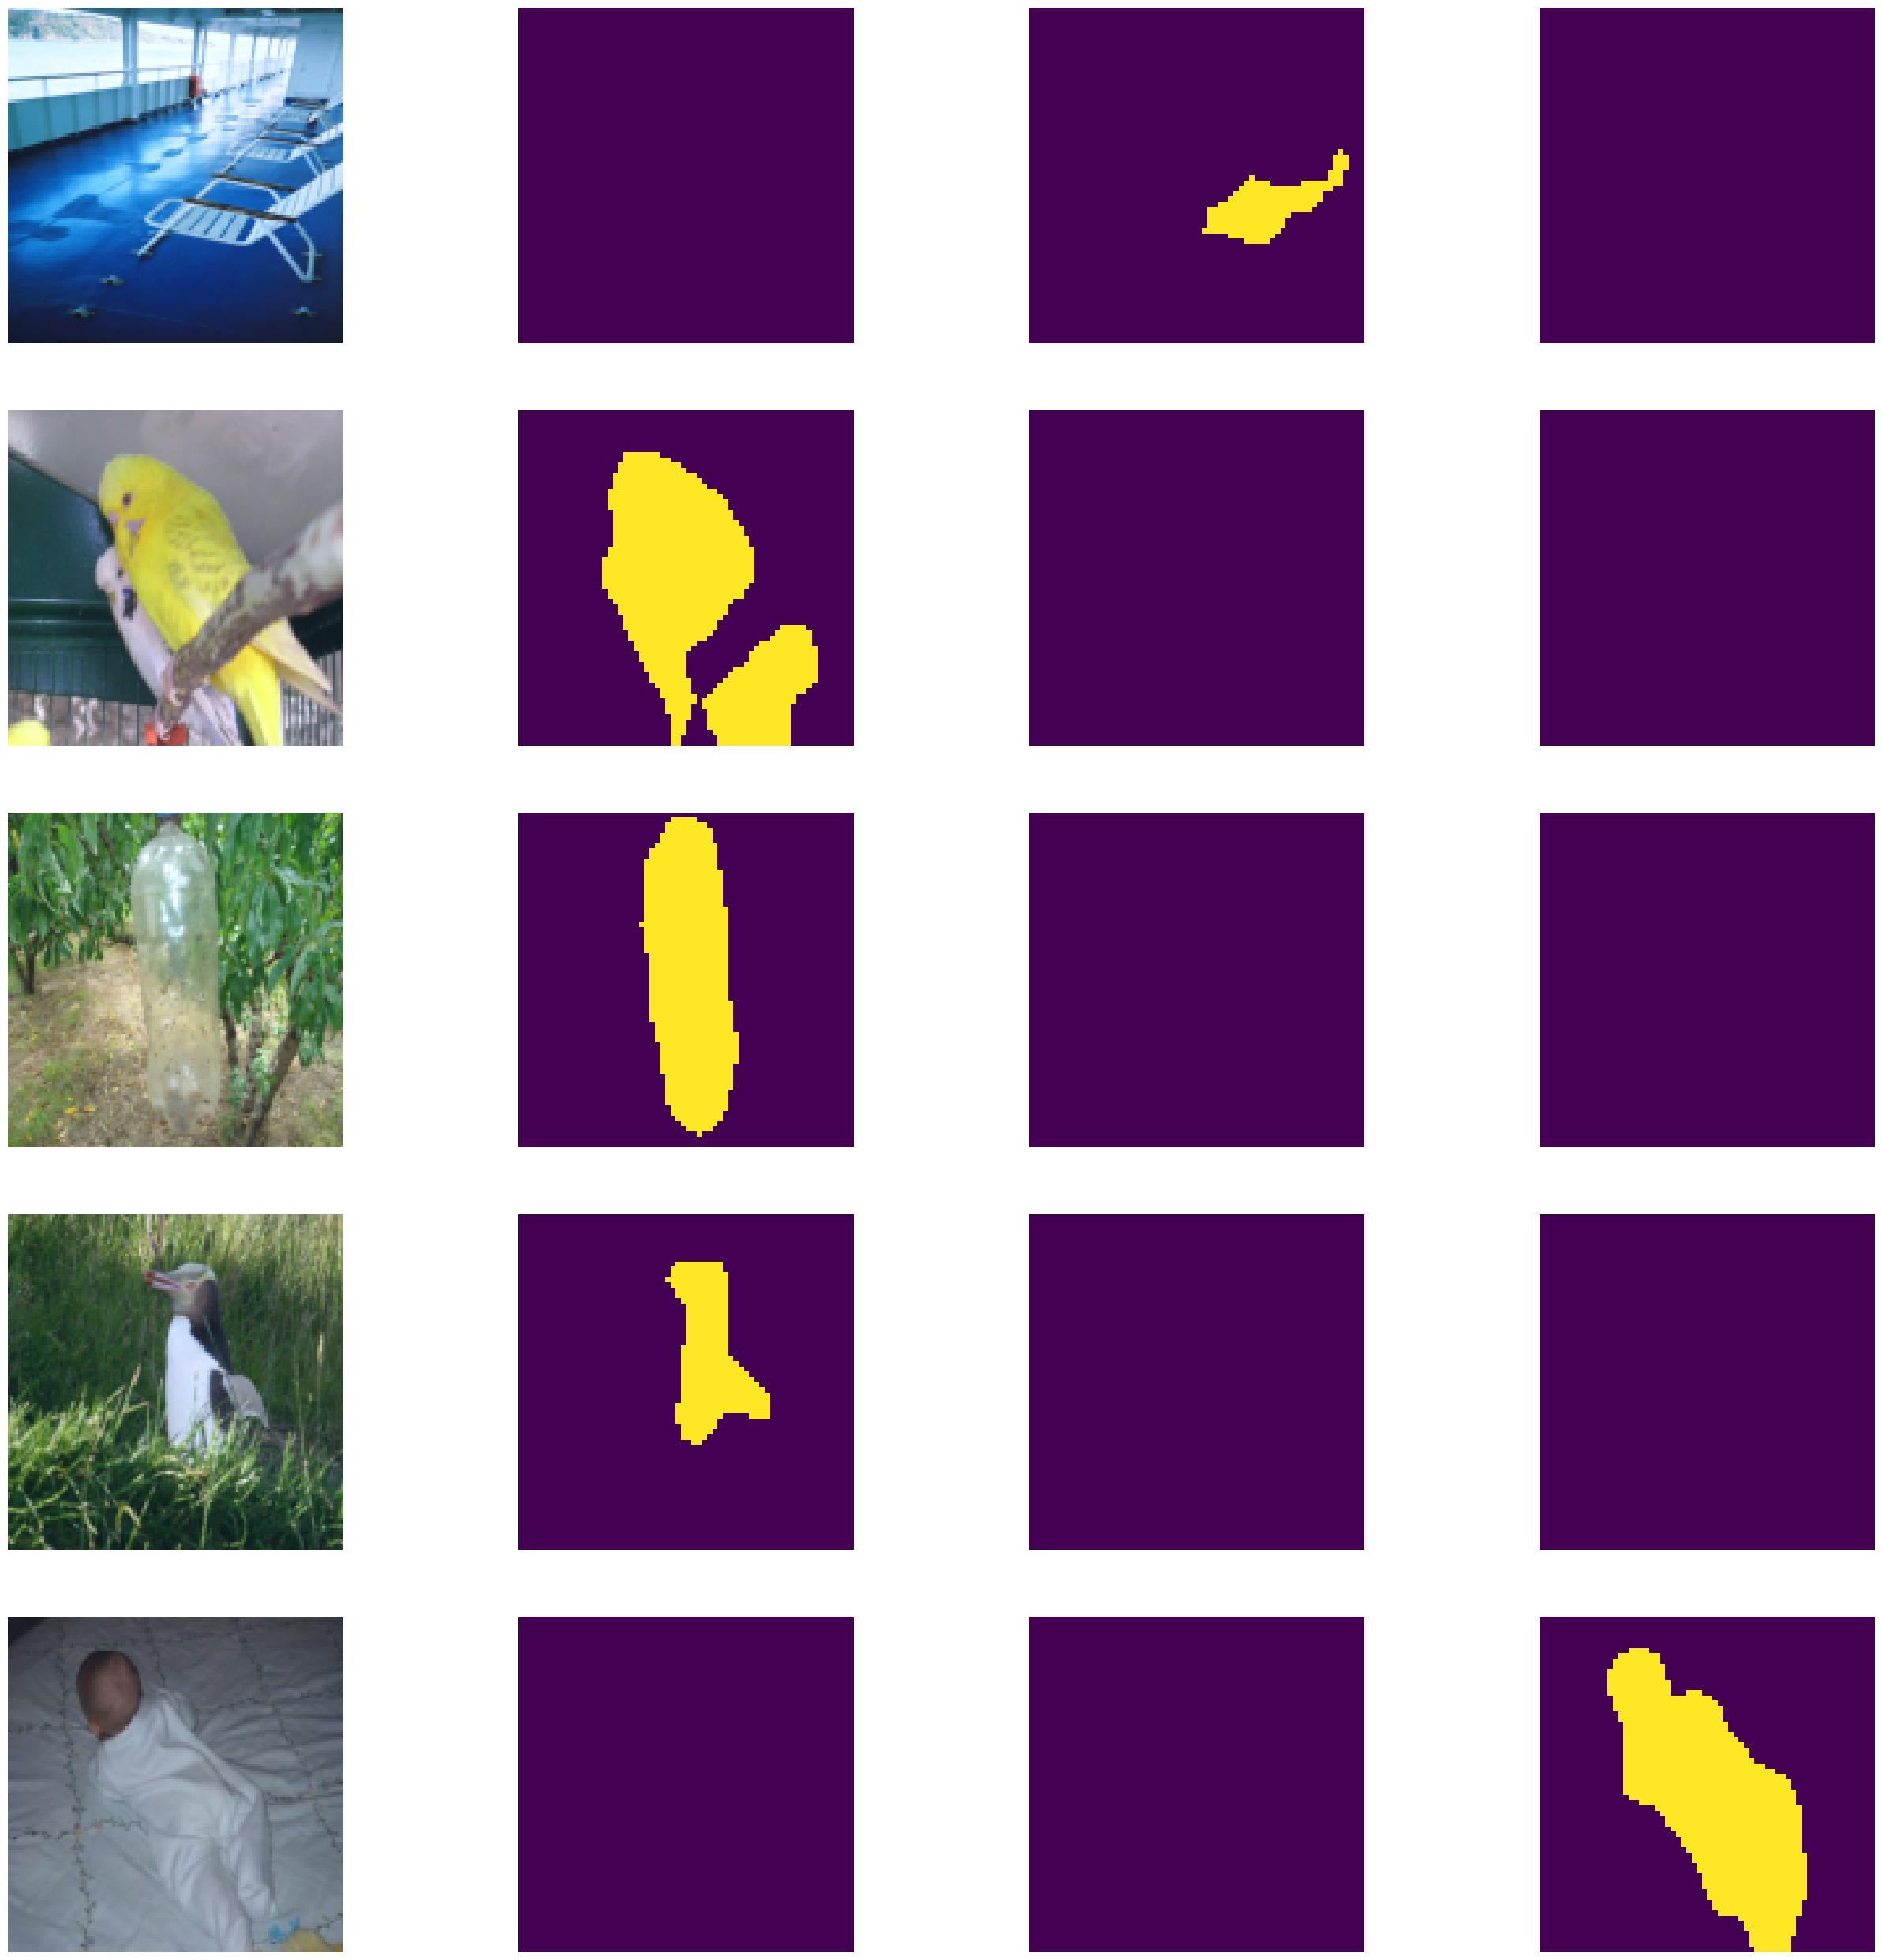

In [35]:
samples = next(iter(TRAIN_LOADER))
images, masks = samples

with torch.no_grad():
    pred = model(images.to(DEVICE))
    pred = torch.argmax(pred, dim=-3).cpu()


visualize_data(images[:5], pred[:5])

### Best and Worst Predictions - 2 point
Visualize the best and worst prediction made by the model on the test set (according to the accuracy metric) per each class in the dataset.
Compare them with ground truths. Do you notice any problems? If you notice problems then how can they be addressed?

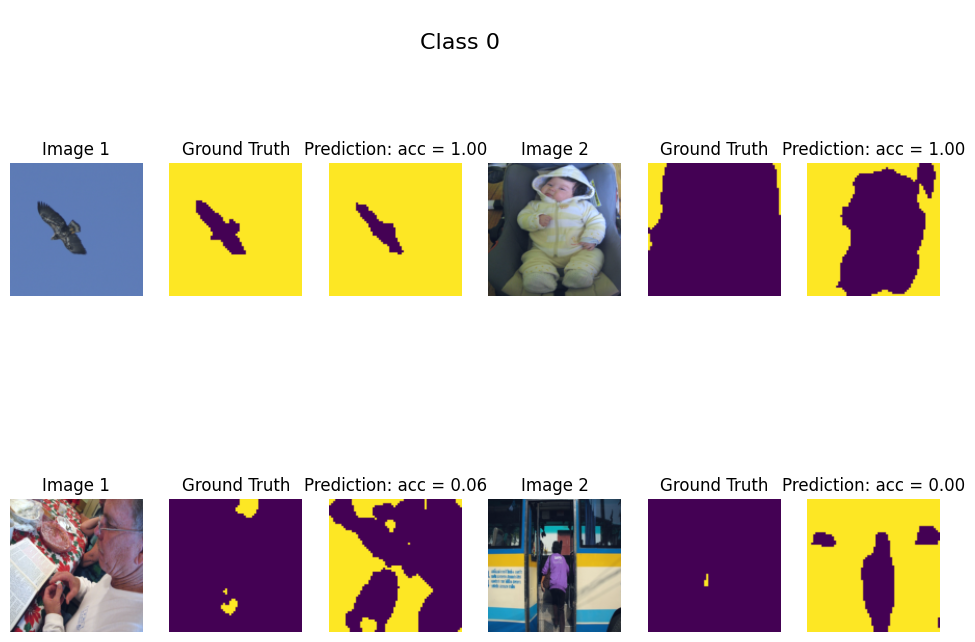

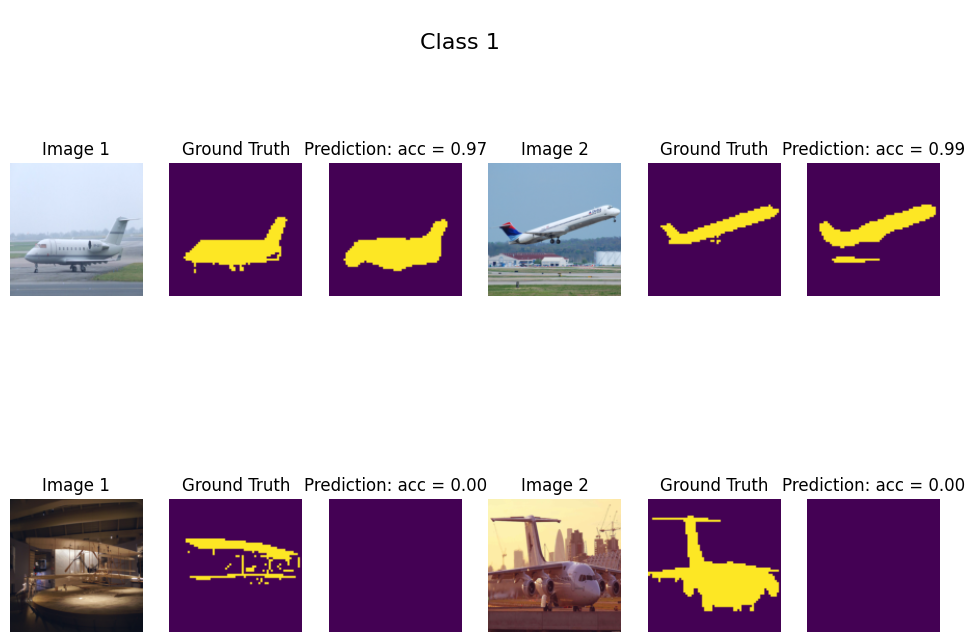

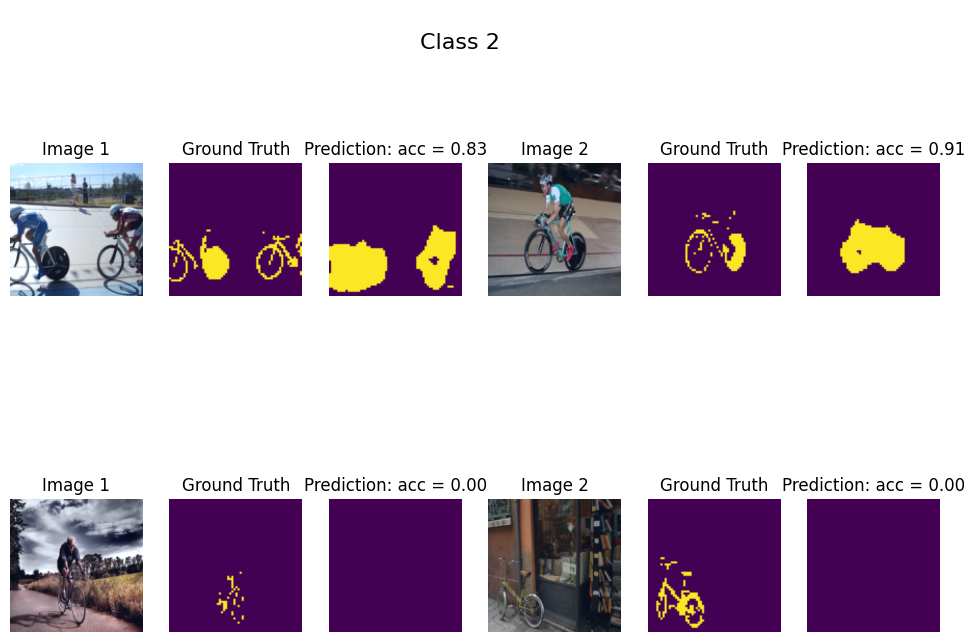

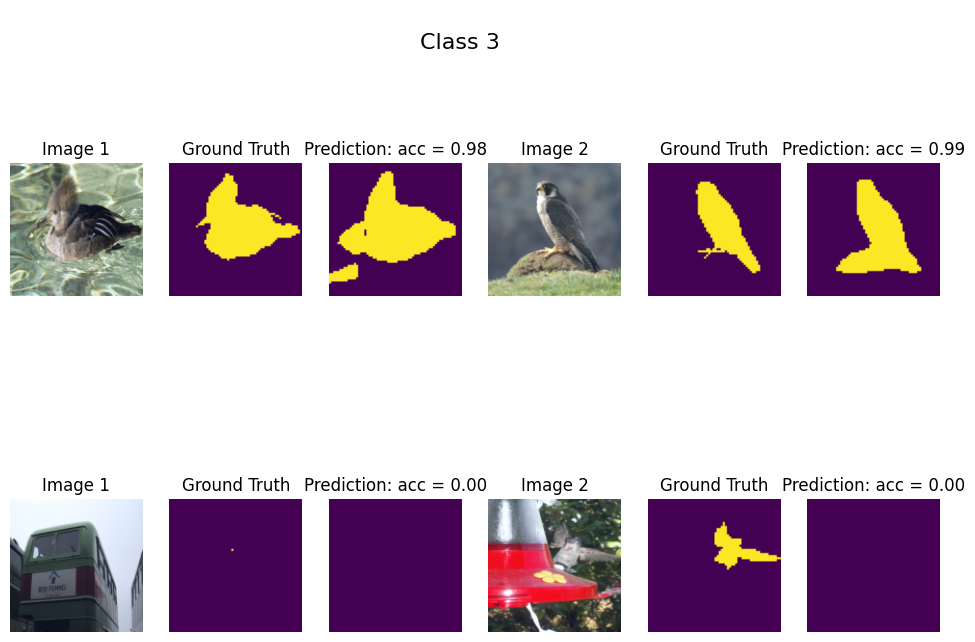

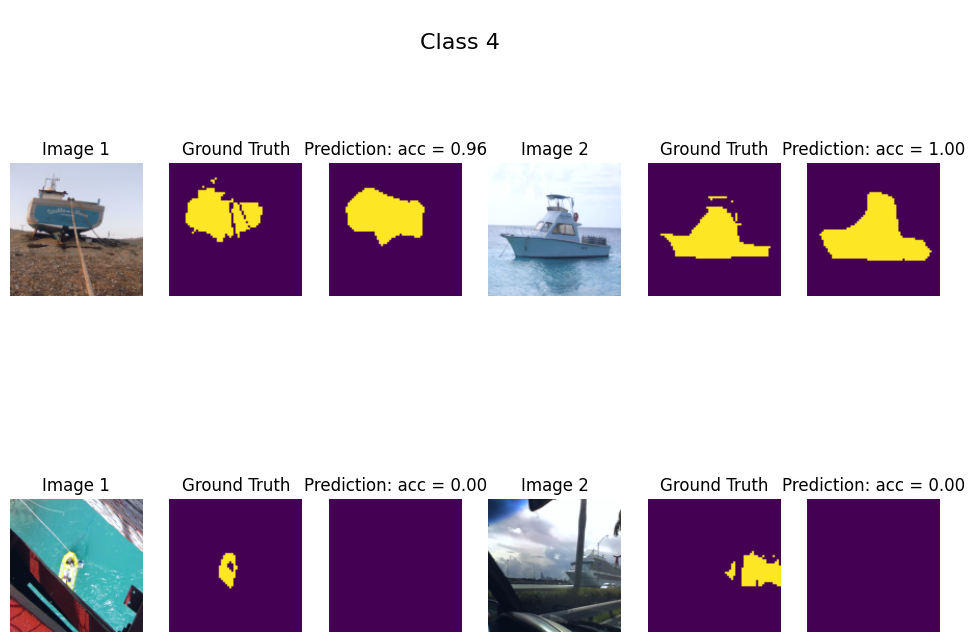

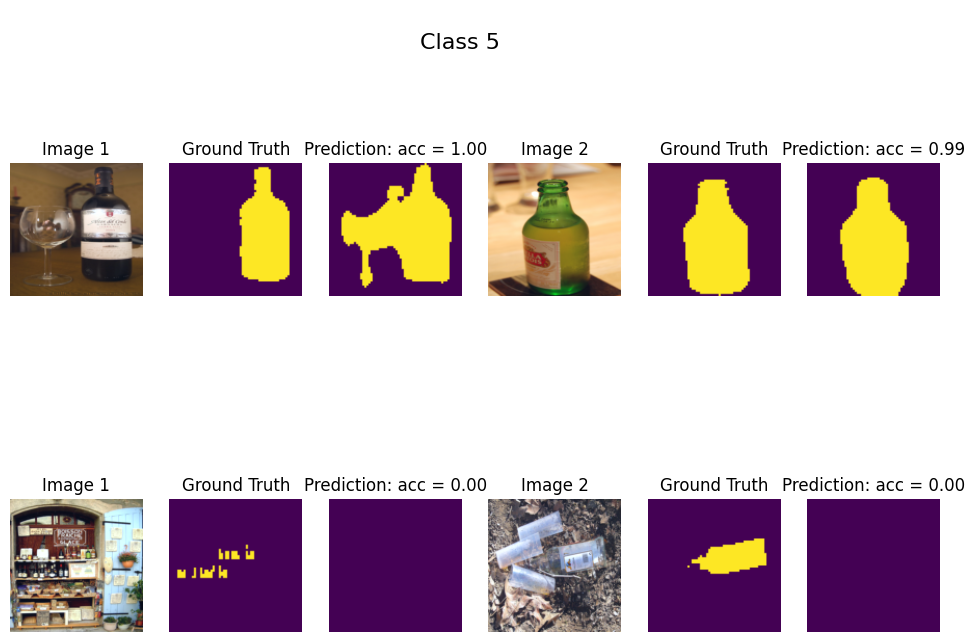

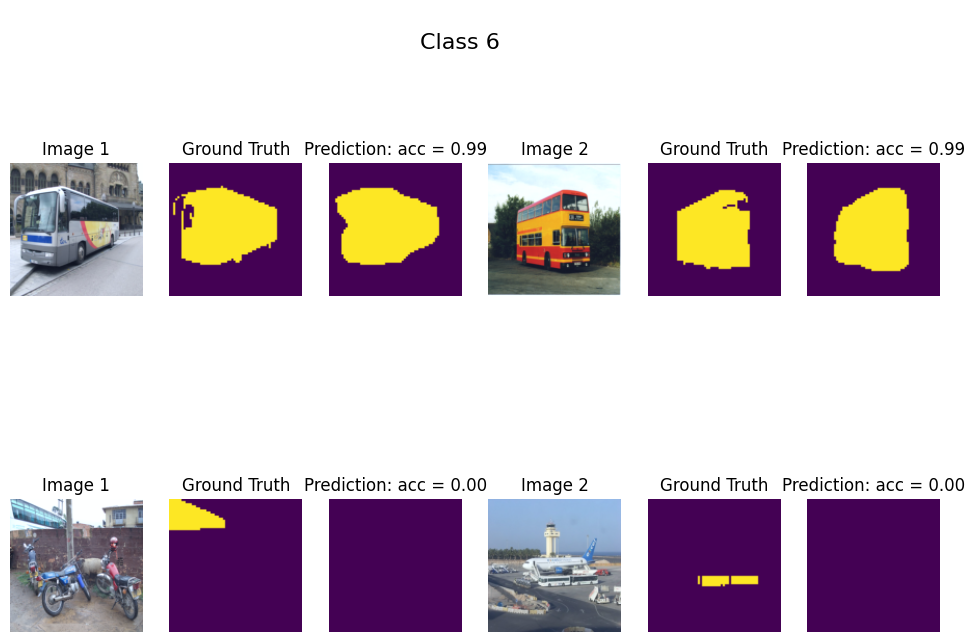

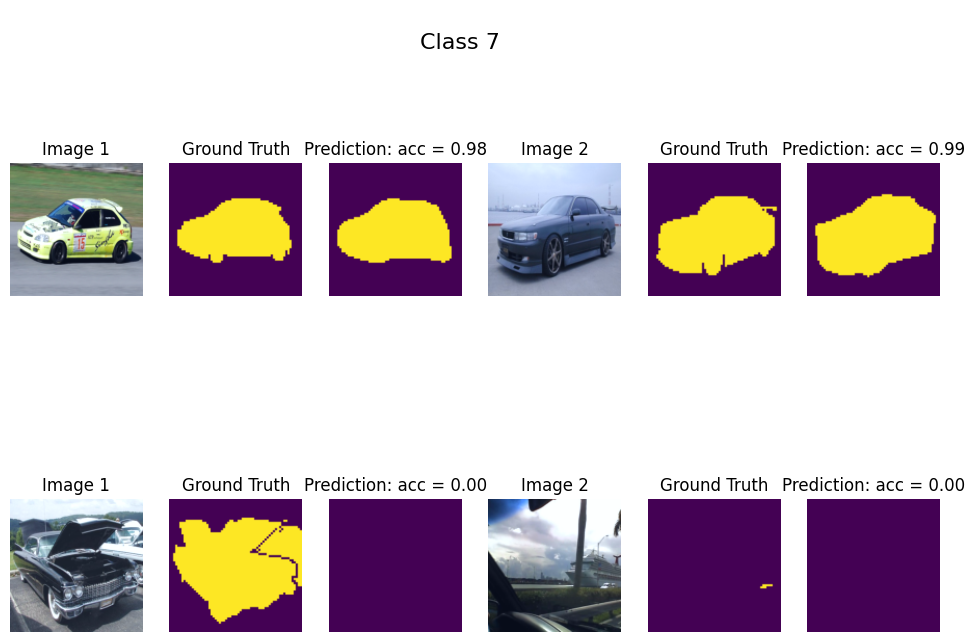

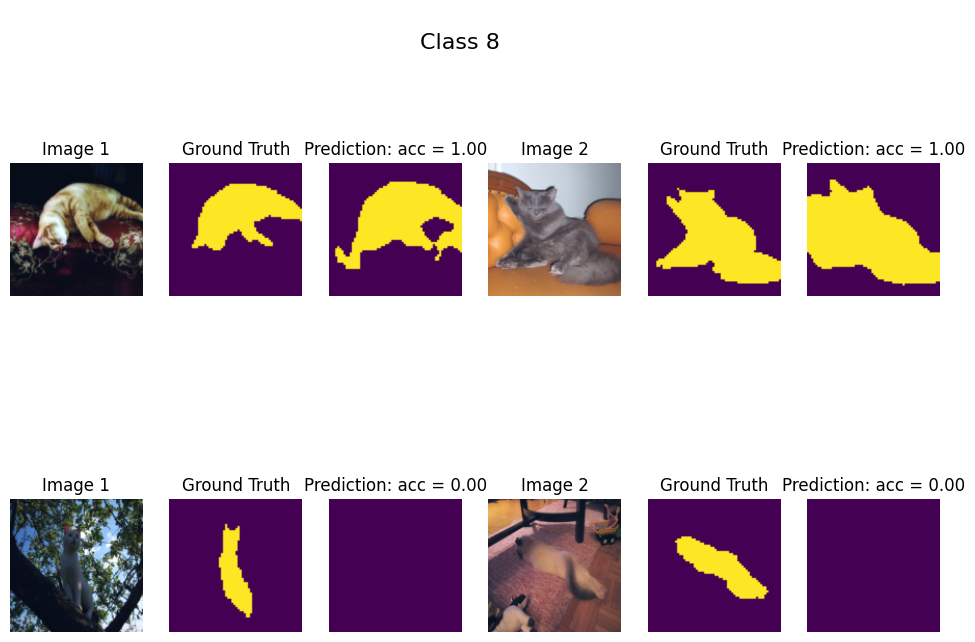

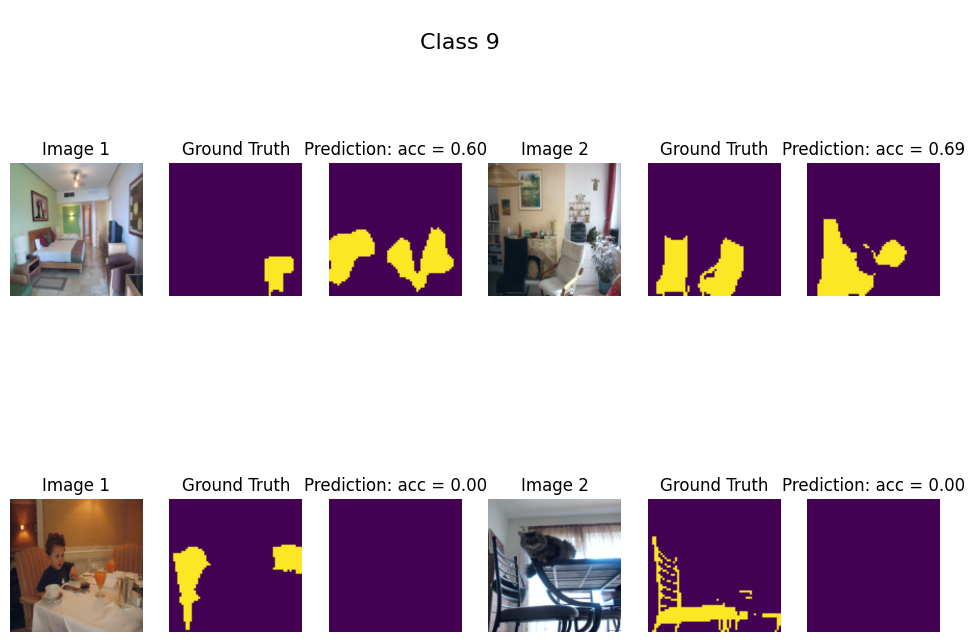

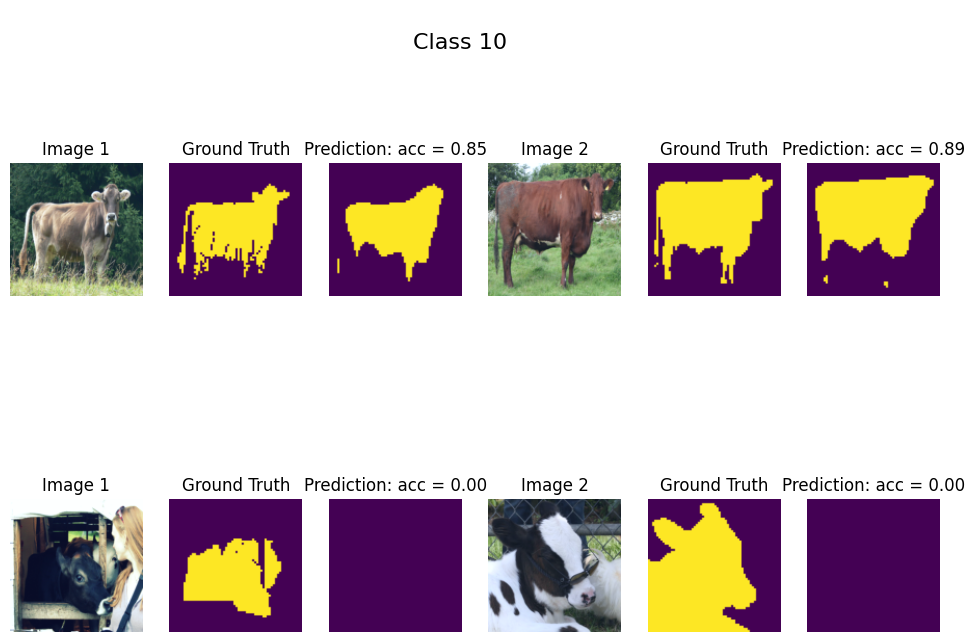

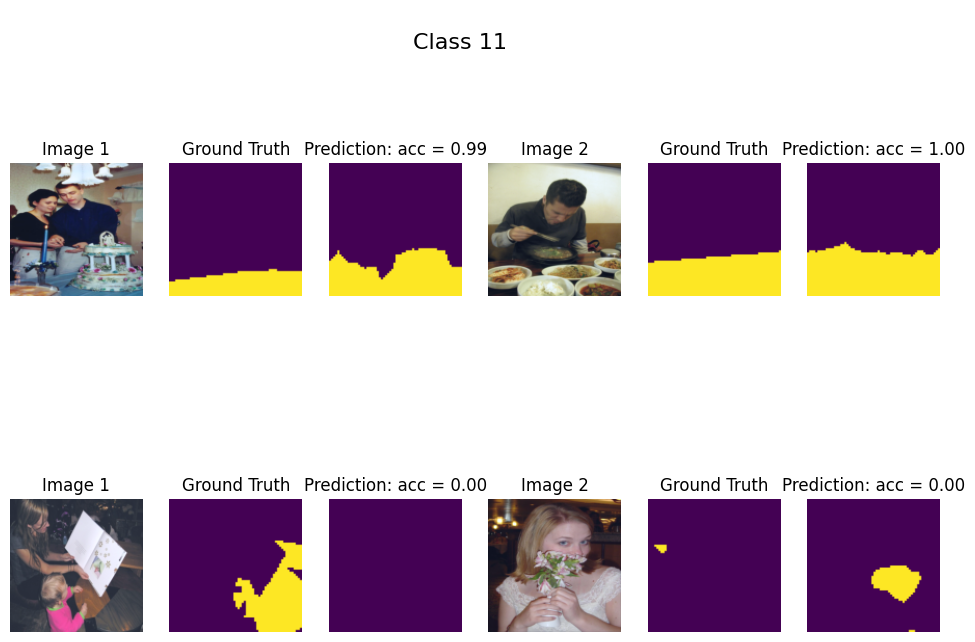

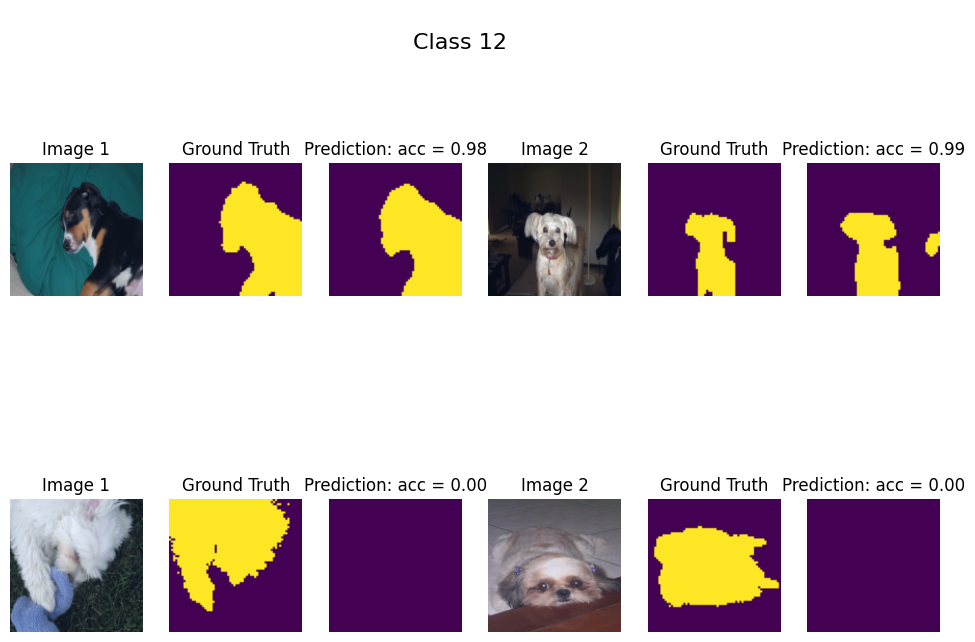

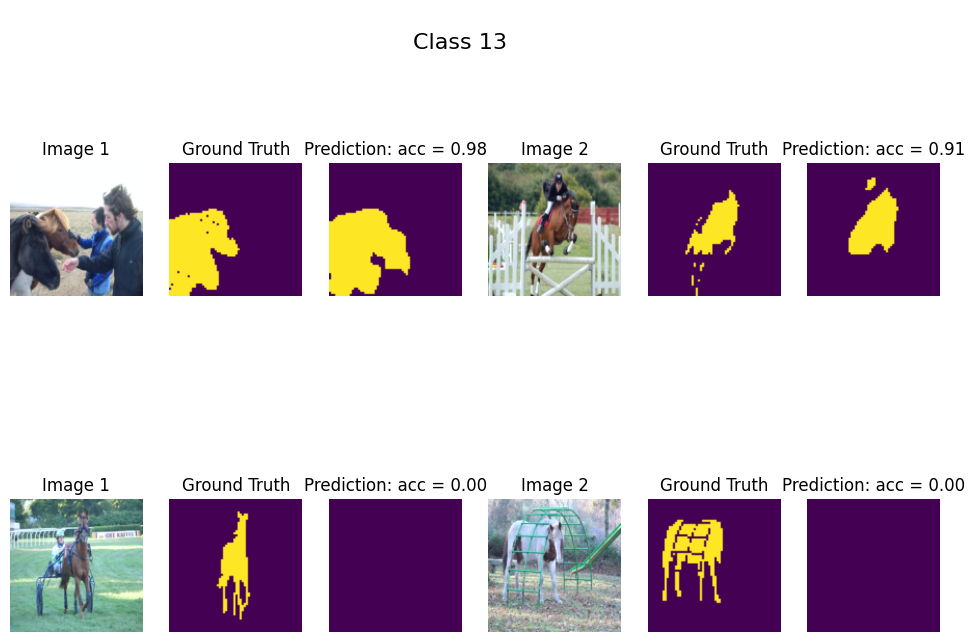

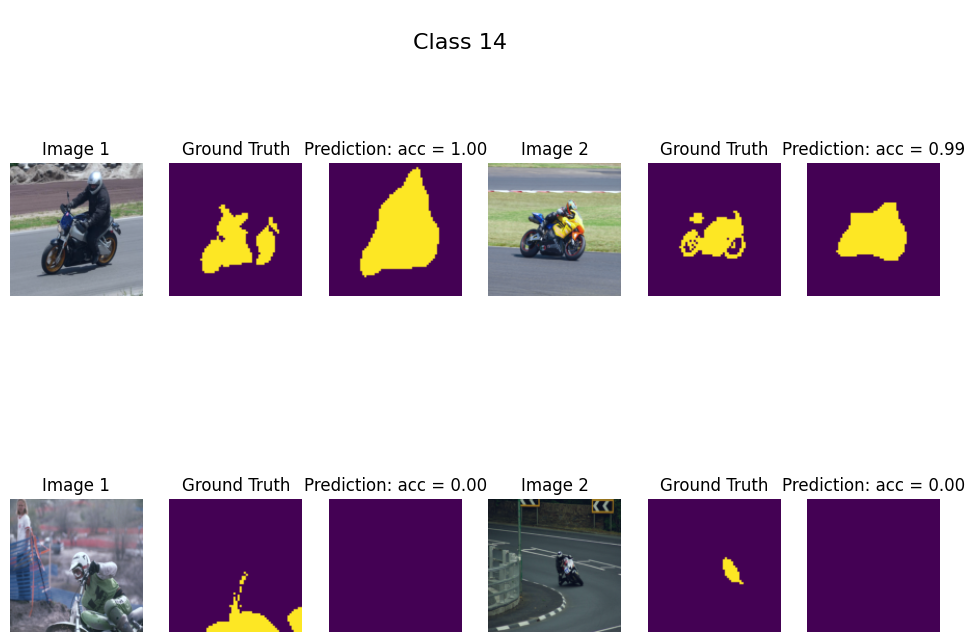

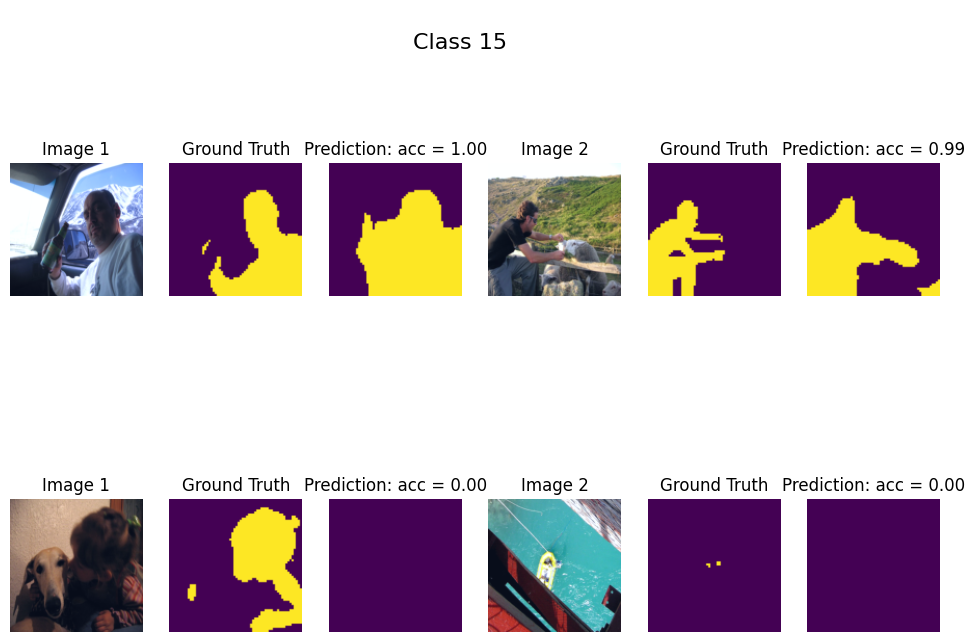

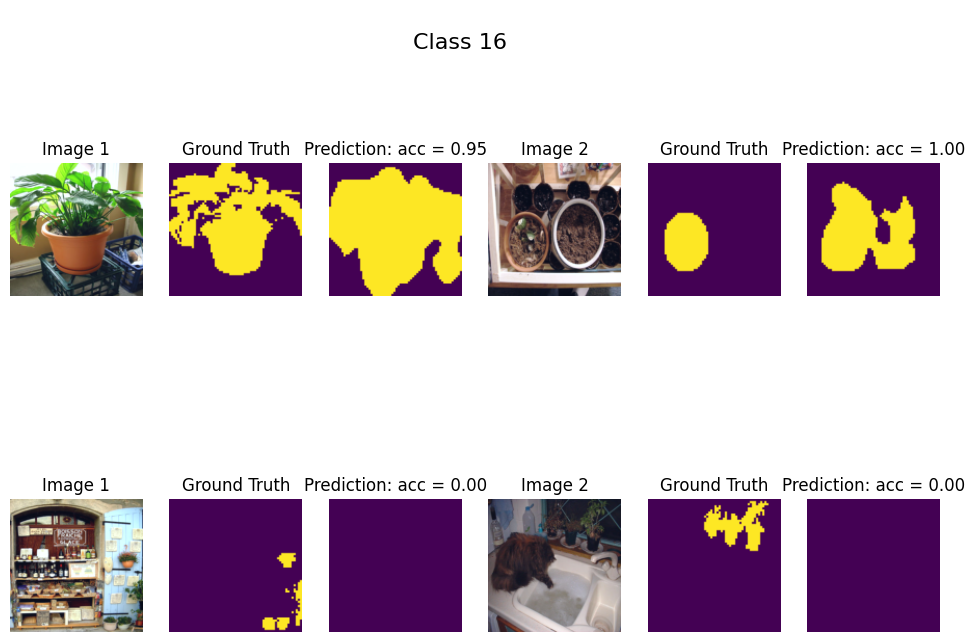

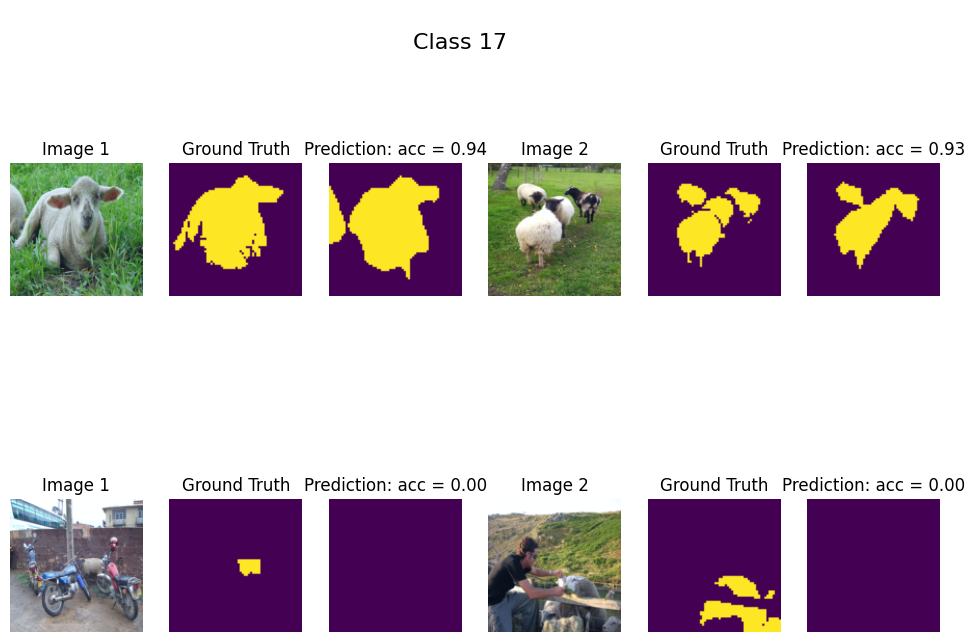

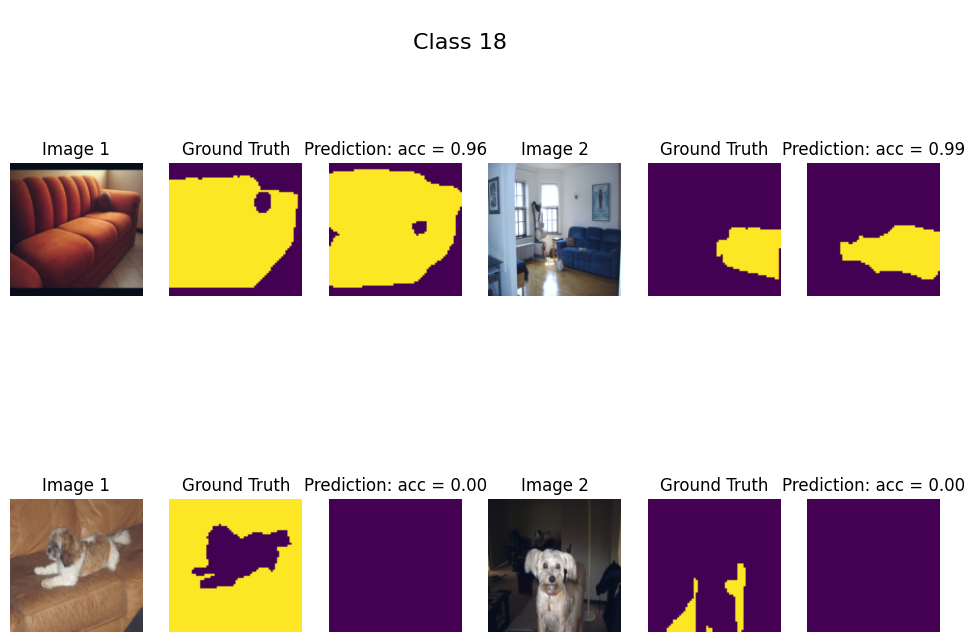

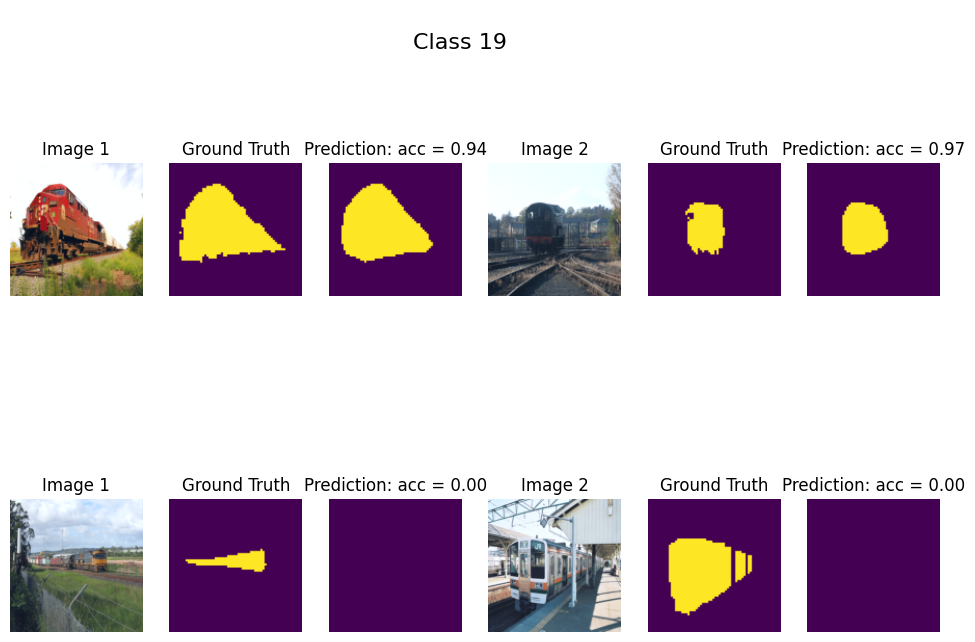

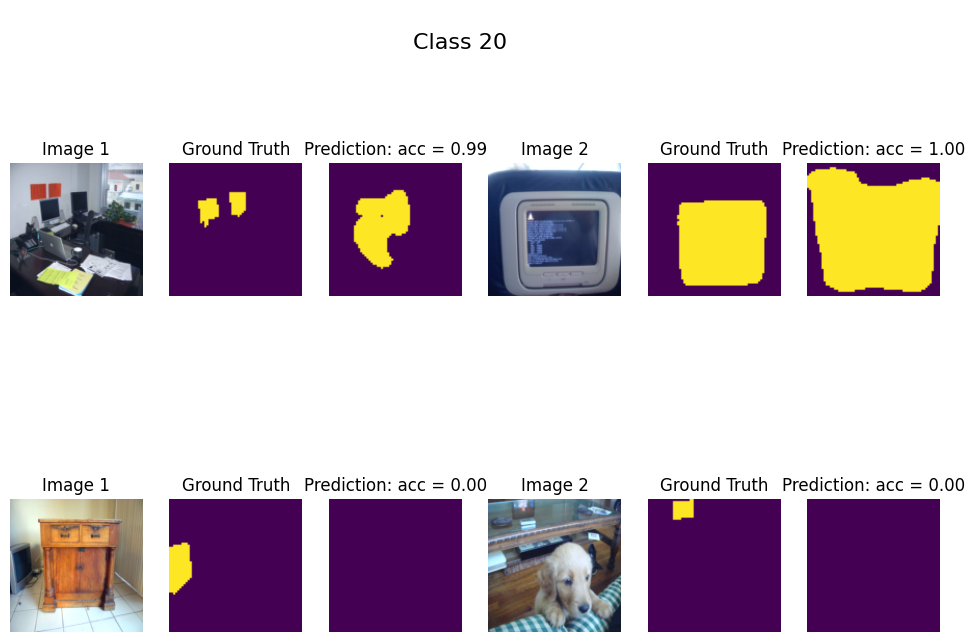

In [49]:
## TODO {
# CODE

def visualize_predictions(model, test_loader, num_classes, num_examples=2):
    model.eval()
    model.to(DEVICE)

    results = {
        cl: {
            'best': {'image': [], 'gt': [], 'pred': [], 'accuracy': []},
            'worst': {'image': [], 'gt': [], 'pred': [], 'accuracy': []}
        } for cl in range(num_classes)
    }

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            masks_np = masks.cpu().numpy()
            preds_np = preds.cpu().numpy()

            for i in range(images.size(0)):
                acc_dict = accuracy_per_class(preds_np[i], masks_np[i])

                for cl, acc in acc_dict.items():
                    if cl >= num_classes:
                        continue

                    if len(results[cl]['best']['accuracy']) < num_examples:
                        results[cl]['best']['accuracy'].append(acc)
                        results[cl]['best']['image'].append(images[i].cpu())
                        results[cl]['best']['gt'].append(masks[i].cpu())
                        results[cl]['best']['pred'].append(preds[i].cpu())
                    else:
                        min_best_acc = min(results[cl]['best']['accuracy'])
                        if acc > min_best_acc:
                            idx = results[cl]['best']['accuracy'].index(min_best_acc)
                            results[cl]['best']['accuracy'][idx] = acc
                            results[cl]['best']['image'][idx] = images[i].cpu()
                            results[cl]['best']['gt'][idx] = masks[i].cpu()
                            results[cl]['best']['pred'][idx] = preds[i].cpu()

                    if len(results[cl]['worst']['accuracy']) < num_examples:
                        results[cl]['worst']['accuracy'].append(acc)
                        results[cl]['worst']['image'].append(images[i].cpu())
                        results[cl]['worst']['gt'].append(masks[i].cpu())
                        results[cl]['worst']['pred'].append(preds[i].cpu())
                    else:
                        max_worst_acc = max(results[cl]['worst']['accuracy'])
                        if acc < max_worst_acc:
                            idx = results[cl]['worst']['accuracy'].index(max_worst_acc)
                            results[cl]['worst']['accuracy'][idx] = acc
                            results[cl]['worst']['image'][idx] = images[i].cpu()
                            results[cl]['worst']['gt'][idx] = masks[i].cpu()
                            results[cl]['worst']['pred'][idx] = preds[i].cpu()

    for cl in range(num_classes):
        if not results[cl]['best']['accuracy']:
            continue

        fig, axes = plt.subplots(2, 3*num_examples, figsize=(6*num_examples, 8))
        fig.suptitle(f"\nClass {cl}", fontsize=16)

        for i in range(num_examples):
            img = results[cl]['best']['image'][i]
            gt = results[cl]['best']['gt'][i]
            pred = results[cl]['best']['pred'][i]
            acc = results[cl]['best']['accuracy'][i]

            axes[0, i*3].imshow(np.clip(img.permute(1, 2, 0).numpy()/4.5 + 0.5, 0, 1))
            axes[0, i*3].set_title(f"Image {i+1}")
            axes[0, i*3].axis('off')

            axes[0, i*3+1].imshow(gt == cl)
            axes[0, i*3+1].set_title("Ground Truth")
            axes[0, i*3+1].axis('off')

            axes[0, i*3+2].imshow(pred == cl)
            axes[0, i*3+2].set_title(f"Prediction: acc = {acc:.2f}")
            axes[0, i*3+2].axis('off')

        for i in range(num_examples):
            img = results[cl]['worst']['image'][i]
            gt = results[cl]['worst']['gt'][i]
            pred = results[cl]['worst']['pred'][i]
            acc = results[cl]['worst']['accuracy'][i]

            axes[1, i*3].imshow(np.clip(img.permute(1, 2, 0).numpy()/4.5 + 0.5, 0, 1))
            axes[1, i*3].set_title(f"Image {i+1}")
            axes[1, i*3].axis('off')

            axes[1, i*3+1].imshow(gt == cl)
            axes[1, i*3+1].set_title("Ground Truth")
            axes[1, i*3+1].axis('off')

            axes[1, i*3+2].imshow(pred == cl)
            axes[1, i*3+2].set_title(f"Prediction: acc = {acc:.2f}")
            axes[1, i*3+2].axis('off')

        plt.show()

visualize_predictions(model, TEST_LOADER, num_classes=21)

##}

## TODO {
# Answer
# We can clearly see the problem with predictions according to the accuracy.
# For example if an object covers only 5% of the image and model predicts the entire image
#     the same as this object so it will get accuracy = 1, so it's not good, but a metric says it's a good performance.
# This kind of problem we can see for the class 5 below, which is a bottle.
#     Model predicts a bottle and a glass together and we get accuracy=1, which is not good.
# That's why better is to use metric such as intersection over union. In the case when the model predicts
#     more pixels than it should then the union will be higher so the IoU will be lower.
#
# The second problem we can see that the model has problems with small objects,
#     objects that are not quite good visible or when there are a lot of objects in the image.
# I believe what we can do is:
#     - when the model has problems with small objects then maybe we could transform data (e.g. higher resolution).
#     - try to use different loss (maybe there is a loss that give high penalties for missing small objects).
#     - oversample images with small objects classes
## }



### Ablations  - 3 points

train several instances for semantic segmentation, ablate with respect to:

1. Backbone: EfficientNet and Resnet50

2. different number of BiFPN modules (num_repeats 1, 3, 5 and possibly more),

3. Training Loss CrossEntropy and Dice

Perform **8** experiments in total.

Identify the configuration achieving the highest mIoU metric for all classess simultaneously.

In [27]:
## TODO {
# CODE

def run_different_configs():
    configs = [
        {'backbone': 'resnet50', 'num_repeats': 1, 'loss': 'crossentropy', 'layer_ids': [2, 3]},
        {'backbone': 'resnet50', 'num_repeats': 3, 'loss': 'crossentropy', 'layer_ids': [2, 3]},
        {'backbone': 'resnet50', 'num_repeats': 5, 'loss': 'crossentropy', 'layer_ids': [2, 3]},
        {'backbone': 'resnet50', 'num_repeats': 3, 'loss': 'dice', 'layer_ids': [2, 3]},
        {'backbone': 'efficientnet', 'num_repeats': 1, 'loss': 'crossentropy', 'layer_ids': [2, 4, 6]},
        {'backbone': 'efficientnet', 'num_repeats': 3, 'loss': 'crossentropy', 'layer_ids': [2, 4, 6]},
        {'backbone': 'efficientnet', 'num_repeats': 5, 'loss': 'crossentropy', 'layer_ids': [2, 4, 6]},
        {'backbone': 'efficientnet', 'num_repeats': 3, 'loss': 'dice', 'layer_ids': [2, 4, 6]},
    ]

    results = []

    for config in configs:
        print(f"\nTraining config: {config}")

        model, optimizer = create_model_and_optimizer(
            backbone=config['backbone'],
            num_repeats=config['num_repeats'],
            feature_layer_ids=config['layer_ids']
        )

        if config['loss'] == 'crossentropy':
            train_fn = train_crossentropy
        else:
            train_fn = train_dice

        train_fn(
            model=model,
            optimizer=optimizer,
            train_loader=TRAIN_LOADER,
            test_loader=TEST_LOADER,
            num_epoch=10,
            eval_fn=eval_fn
        )

        val_acc, val_acc_per_class, val_iou_per_class, val_miou, val_fw_iou = eval_fn(model, TEST_LOADER)

        results.append({
            **config,
            'accuracy': val_acc,
            'mIoU': val_miou,
            'freq_weighted_IoU': val_fw_iou
        })

    return results

result = run_different_configs()

best_config = max(result, key=lambda x: x['mIoU'])

print("Best Configuration:")
print(f"Backbone: {best_config['backbone']}")
print(f"Number repeats: {best_config['num_repeats']}")
print(f"Loss function: {best_config['loss']}")
print(f"Layer ids: {best_config['layer_ids']}")
print(f"mIoU: {best_config['mIoU']:.4f}")



##}

## TODO {
# Answer
# So I've perform 8 experiments. Each run with different num_repeats loss or backbone.
# The best one, achieving the highest mIoU (0.3845) is a run with configs:
#     backbone: 'efficientnet', num_repeats=1, loss=crossentropy, layer_ids=[2,4,6]
# I've printed all the results below by mIoU descending order. We can see that
#     the second one is also with num_reapets=1 but with backbone: 'resnet50'.
# The worst ones are with backbone: 'resnet50', num_repeats=3, 5, loss=dice, crossentrop
#     achieving mIoU: 0.16
#
# We can see that better results are for lower number of repeats.
# Maybe if we would have more training data and train longer (more epochs)
#     then the results for higher number of repeats would be better.
## }



Training config: {'backbone': 'resnet50', 'num_repeats': 1, 'loss': 'crossentropy', 'layer_ids': [2, 3]}


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


[Epoch 1/10] Batch 0/35 | Loss: 3.1496
[Epoch 1/10] Batch 5/35 | Loss: 2.0061
[Epoch 1/10] Batch 10/35 | Loss: 1.2308
[Epoch 1/10] Batch 15/35 | Loss: 1.2346
[Epoch 1/10] Batch 20/35 | Loss: 0.8136
[Epoch 1/10] Batch 25/35 | Loss: 0.8692
[Epoch 1/10] Batch 30/35 | Loss: 0.7633

Epoch 1 Training Loss: 1.3017
Train eval metrics | Acc: 0.7757 | mIoU: 0.1557 | fw IoU: 0.6571
Test eval metrics | Acc: 0.7500 | mIoU: 0.1318 | fw IoU: 0.6231

[Epoch 2/10] Batch 0/35 | Loss: 0.6511
[Epoch 2/10] Batch 5/35 | Loss: 0.5107
[Epoch 2/10] Batch 10/35 | Loss: 0.7195
[Epoch 2/10] Batch 15/35 | Loss: 0.6603
[Epoch 2/10] Batch 20/35 | Loss: 0.6021
[Epoch 2/10] Batch 25/35 | Loss: 0.6213
[Epoch 2/10] Batch 30/35 | Loss: 0.5958

Epoch 2 Training Loss: 0.6114
Train eval metrics | Acc: 0.8288 | mIoU: 0.2866 | fw IoU: 0.7233
Test eval metrics | Acc: 0.7800 | mIoU: 0.1661 | fw IoU: 0.6483

[Epoch 3/10] Batch 0/35 | Loss: 0.4963
[Epoch 3/10] Batch 5/35 | Loss: 0.4682
[Epoch 3/10] Batch 10/35 | Loss: 0.5717
[Epo

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


[Epoch 1/10] Batch 0/35 | Loss: 3.1908
[Epoch 1/10] Batch 5/35 | Loss: 1.7273
[Epoch 1/10] Batch 10/35 | Loss: 1.5254
[Epoch 1/10] Batch 15/35 | Loss: 1.0594
[Epoch 1/10] Batch 20/35 | Loss: 1.1965
[Epoch 1/10] Batch 25/35 | Loss: 0.8791
[Epoch 1/10] Batch 30/35 | Loss: 0.8285

Epoch 1 Training Loss: 1.3214
Train eval metrics | Acc: 0.7715 | mIoU: 0.0924 | fw IoU: 0.6408
Test eval metrics | Acc: 0.7564 | mIoU: 0.0845 | fw IoU: 0.6135

[Epoch 2/10] Batch 0/35 | Loss: 0.9112
[Epoch 2/10] Batch 5/35 | Loss: 0.7851
[Epoch 2/10] Batch 10/35 | Loss: 0.7865
[Epoch 2/10] Batch 15/35 | Loss: 0.7604
[Epoch 2/10] Batch 20/35 | Loss: 0.6813
[Epoch 2/10] Batch 25/35 | Loss: 0.7543
[Epoch 2/10] Batch 30/35 | Loss: 0.7524

Epoch 2 Training Loss: 0.7552
Train eval metrics | Acc: 0.8054 | mIoU: 0.1395 | fw IoU: 0.6878
Test eval metrics | Acc: 0.7737 | mIoU: 0.1066 | fw IoU: 0.6447

[Epoch 3/10] Batch 0/35 | Loss: 0.8733
[Epoch 3/10] Batch 5/35 | Loss: 0.7163
[Epoch 3/10] Batch 10/35 | Loss: 0.6400
[Epo

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


[Epoch 1/10] Batch 0/35 | Loss: 3.2216
[Epoch 1/10] Batch 5/35 | Loss: 2.0432
[Epoch 1/10] Batch 10/35 | Loss: 1.4884
[Epoch 1/10] Batch 15/35 | Loss: 1.0561
[Epoch 1/10] Batch 20/35 | Loss: 1.0872
[Epoch 1/10] Batch 25/35 | Loss: 0.8064
[Epoch 1/10] Batch 30/35 | Loss: 0.9739

Epoch 1 Training Loss: 1.4277
Train eval metrics | Acc: 0.7805 | mIoU: 0.0991 | fw IoU: 0.6448
Test eval metrics | Acc: 0.7587 | mIoU: 0.0804 | fw IoU: 0.6151

[Epoch 2/10] Batch 0/35 | Loss: 0.9354
[Epoch 2/10] Batch 5/35 | Loss: 0.7290
[Epoch 2/10] Batch 10/35 | Loss: 0.8680
[Epoch 2/10] Batch 15/35 | Loss: 0.7979
[Epoch 2/10] Batch 20/35 | Loss: 0.9581
[Epoch 2/10] Batch 25/35 | Loss: 0.9344
[Epoch 2/10] Batch 30/35 | Loss: 0.7514

Epoch 2 Training Loss: 0.8554
Train eval metrics | Acc: 0.7899 | mIoU: 0.1084 | fw IoU: 0.6654
Test eval metrics | Acc: 0.7618 | mIoU: 0.0930 | fw IoU: 0.6292

[Epoch 3/10] Batch 0/35 | Loss: 0.7649
[Epoch 3/10] Batch 5/35 | Loss: 0.5909
[Epoch 3/10] Batch 10/35 | Loss: 0.8257
[Epo

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


[Epoch 1/10] Batch 0/35 | Loss: 0.9804
[Epoch 1/10] Batch 5/35 | Loss: 0.8917
[Epoch 1/10] Batch 10/35 | Loss: 0.9357
[Epoch 1/10] Batch 15/35 | Loss: 0.8879
[Epoch 1/10] Batch 20/35 | Loss: 0.8927
[Epoch 1/10] Batch 25/35 | Loss: 0.8961
[Epoch 1/10] Batch 30/35 | Loss: 0.9010

Epoch 1 Training Loss: 0.9066
Train eval metrics | Acc: 0.3847 | mIoU: 0.0613 | fw IoU: 0.3235
Test eval metrics | Acc: 0.3611 | mIoU: 0.0539 | fw IoU: 0.3118

[Epoch 2/10] Batch 0/35 | Loss: 0.8655
[Epoch 2/10] Batch 5/35 | Loss: 0.8373
[Epoch 2/10] Batch 10/35 | Loss: 0.8060
[Epoch 2/10] Batch 15/35 | Loss: 0.8010
[Epoch 2/10] Batch 20/35 | Loss: 0.8739
[Epoch 2/10] Batch 25/35 | Loss: 0.8697
[Epoch 2/10] Batch 30/35 | Loss: 0.8367

Epoch 2 Training Loss: 0.8507
Train eval metrics | Acc: 0.5986 | mIoU: 0.1094 | fw IoU: 0.5113
Test eval metrics | Acc: 0.5824 | mIoU: 0.0952 | fw IoU: 0.5021

[Epoch 3/10] Batch 0/35 | Loss: 0.8383
[Epoch 3/10] Batch 5/35 | Loss: 0.8393
[Epoch 3/10] Batch 10/35 | Loss: 0.7916
[Epo

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


[Epoch 1/10] Batch 0/35 | Loss: 2.7991
[Epoch 1/10] Batch 5/35 | Loss: 1.5755
[Epoch 1/10] Batch 10/35 | Loss: 1.2154
[Epoch 1/10] Batch 15/35 | Loss: 0.9050
[Epoch 1/10] Batch 20/35 | Loss: 0.7619
[Epoch 1/10] Batch 25/35 | Loss: 1.0102
[Epoch 1/10] Batch 30/35 | Loss: 0.8602

Epoch 1 Training Loss: 1.1779
Train eval metrics | Acc: 0.8088 | mIoU: 0.1219 | fw IoU: 0.6871
Test eval metrics | Acc: 0.7871 | mIoU: 0.1094 | fw IoU: 0.6554

[Epoch 2/10] Batch 0/35 | Loss: 0.6546
[Epoch 2/10] Batch 5/35 | Loss: 0.6762
[Epoch 2/10] Batch 10/35 | Loss: 0.8619
[Epoch 2/10] Batch 15/35 | Loss: 0.7461
[Epoch 2/10] Batch 20/35 | Loss: 0.6708
[Epoch 2/10] Batch 25/35 | Loss: 0.8327
[Epoch 2/10] Batch 30/35 | Loss: 0.7151

Epoch 2 Training Loss: 0.6455
Train eval metrics | Acc: 0.8405 | mIoU: 0.2437 | fw IoU: 0.7337
Test eval metrics | Acc: 0.8012 | mIoU: 0.1844 | fw IoU: 0.6791

[Epoch 3/10] Batch 0/35 | Loss: 0.5133
[Epoch 3/10] Batch 5/35 | Loss: 0.5641
[Epoch 3/10] Batch 10/35 | Loss: 0.4796
[Epo

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


[Epoch 1/10] Batch 0/35 | Loss: 3.1157
[Epoch 1/10] Batch 5/35 | Loss: 1.9374
[Epoch 1/10] Batch 10/35 | Loss: 1.4639
[Epoch 1/10] Batch 15/35 | Loss: 1.0744
[Epoch 1/10] Batch 20/35 | Loss: 1.0453
[Epoch 1/10] Batch 25/35 | Loss: 1.0717
[Epoch 1/10] Batch 30/35 | Loss: 0.8097

Epoch 1 Training Loss: 1.3437
Train eval metrics | Acc: 0.7630 | mIoU: 0.0937 | fw IoU: 0.6653
Test eval metrics | Acc: 0.7406 | mIoU: 0.0851 | fw IoU: 0.6386

[Epoch 2/10] Batch 0/35 | Loss: 0.7644
[Epoch 2/10] Batch 5/35 | Loss: 0.8388
[Epoch 2/10] Batch 10/35 | Loss: 0.9071
[Epoch 2/10] Batch 15/35 | Loss: 0.6473
[Epoch 2/10] Batch 20/35 | Loss: 0.5548
[Epoch 2/10] Batch 25/35 | Loss: 0.6426
[Epoch 2/10] Batch 30/35 | Loss: 0.7098

Epoch 2 Training Loss: 0.7820
Train eval metrics | Acc: 0.8057 | mIoU: 0.1406 | fw IoU: 0.6695
Test eval metrics | Acc: 0.7770 | mIoU: 0.1017 | fw IoU: 0.6321

[Epoch 3/10] Batch 0/35 | Loss: 0.7907
[Epoch 3/10] Batch 5/35 | Loss: 0.6685
[Epoch 3/10] Batch 10/35 | Loss: 0.7197
[Epo

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


[Epoch 1/10] Batch 0/35 | Loss: 3.1952
[Epoch 1/10] Batch 5/35 | Loss: 1.9657
[Epoch 1/10] Batch 10/35 | Loss: 1.5959
[Epoch 1/10] Batch 15/35 | Loss: 1.4175
[Epoch 1/10] Batch 20/35 | Loss: 1.1134
[Epoch 1/10] Batch 25/35 | Loss: 1.1229
[Epoch 1/10] Batch 30/35 | Loss: 1.0018

Epoch 1 Training Loss: 1.4332
Train eval metrics | Acc: 0.7855 | mIoU: 0.1020 | fw IoU: 0.6676
Test eval metrics | Acc: 0.7658 | mIoU: 0.0961 | fw IoU: 0.6400

[Epoch 2/10] Batch 0/35 | Loss: 0.7995
[Epoch 2/10] Batch 5/35 | Loss: 0.7422
[Epoch 2/10] Batch 10/35 | Loss: 1.0763
[Epoch 2/10] Batch 15/35 | Loss: 0.7227
[Epoch 2/10] Batch 20/35 | Loss: 0.5616
[Epoch 2/10] Batch 25/35 | Loss: 0.8400
[Epoch 2/10] Batch 30/35 | Loss: 0.7098

Epoch 2 Training Loss: 0.8226
Train eval metrics | Acc: 0.8038 | mIoU: 0.1232 | fw IoU: 0.6919
Test eval metrics | Acc: 0.7783 | mIoU: 0.1041 | fw IoU: 0.6562

[Epoch 3/10] Batch 0/35 | Loss: 0.6272
[Epoch 3/10] Batch 5/35 | Loss: 0.7013
[Epoch 3/10] Batch 10/35 | Loss: 0.8114
[Epo

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


[Epoch 1/10] Batch 0/35 | Loss: 0.9779
[Epoch 1/10] Batch 5/35 | Loss: 0.9429
[Epoch 1/10] Batch 10/35 | Loss: 0.9019
[Epoch 1/10] Batch 15/35 | Loss: 0.8484
[Epoch 1/10] Batch 20/35 | Loss: 0.8753
[Epoch 1/10] Batch 25/35 | Loss: 0.8590
[Epoch 1/10] Batch 30/35 | Loss: 0.8818

Epoch 1 Training Loss: 0.8999
Train eval metrics | Acc: 0.5489 | mIoU: 0.0836 | fw IoU: 0.4694
Test eval metrics | Acc: 0.5555 | mIoU: 0.0863 | fw IoU: 0.4788

[Epoch 2/10] Batch 0/35 | Loss: 0.8513
[Epoch 2/10] Batch 5/35 | Loss: 0.8790
[Epoch 2/10] Batch 10/35 | Loss: 0.8252
[Epoch 2/10] Batch 15/35 | Loss: 0.8818
[Epoch 2/10] Batch 20/35 | Loss: 0.8387
[Epoch 2/10] Batch 25/35 | Loss: 0.8162
[Epoch 2/10] Batch 30/35 | Loss: 0.8637

Epoch 2 Training Loss: 0.8413
Train eval metrics | Acc: 0.6482 | mIoU: 0.1395 | fw IoU: 0.5691
Test eval metrics | Acc: 0.6333 | mIoU: 0.1285 | fw IoU: 0.5543

[Epoch 3/10] Batch 0/35 | Loss: 0.7958
[Epoch 3/10] Batch 5/35 | Loss: 0.8347
[Epoch 3/10] Batch 10/35 | Loss: 0.8328
[Epo

In [34]:
def print_results(results):
    sorted_results = sorted(results, key=lambda x: x['mIoU'], reverse=True)

    for r in sorted_results:
        print(f"Backbone: {r['backbone']}")
        print(f"Number repeats: {r['num_repeats']}")
        print(f"Loss function: {r['loss']}")
        print(f"Layer ids: {r['layer_ids']}")
        print(f"Accuracy: {r['accuracy']:.4f}")
        print(f"mIoU: {r['mIoU']:.4f}\n")

print_results(result)

Backbone: efficientnet
Number repeats: 1
Loss function: crossentropy
Layer ids: [2, 4, 6]
Accuracy: 0.8411
mIoU: 0.3845

Backbone: resnet50
Number repeats: 1
Loss function: crossentropy
Layer ids: [2, 3]
Accuracy: 0.8281
mIoU: 0.3480

Backbone: efficientnet
Number repeats: 3
Loss function: crossentropy
Layer ids: [2, 4, 6]
Accuracy: 0.8330
mIoU: 0.3275

Backbone: resnet50
Number repeats: 3
Loss function: crossentropy
Layer ids: [2, 3]
Accuracy: 0.7966
mIoU: 0.2728

Backbone: efficientnet
Number repeats: 5
Loss function: crossentropy
Layer ids: [2, 4, 6]
Accuracy: 0.8191
mIoU: 0.2719

Backbone: efficientnet
Number repeats: 3
Loss function: dice
Layer ids: [2, 4, 6]
Accuracy: 0.7687
mIoU: 0.2017

Backbone: resnet50
Number repeats: 3
Loss function: dice
Layer ids: [2, 3]
Accuracy: 0.6934
mIoU: 0.1605

Backbone: resnet50
Number repeats: 5
Loss function: crossentropy
Layer ids: [2, 3]
Accuracy: 0.7755
mIoU: 0.1602

